### Import Data:

In [7]:
import pandas as pd
ratings = pd.read_csv('../Datasets/kaggle_book_recommendation/Ratings.csv')
books = pd.read_csv('../Datasets/kaggle_book_recommendation/Books.csv', dtype={3: 'str'})

In [11]:
len(ratings)

1149780

In [4]:
ratings['User-ID'].nunique()

105283

In [7]:
ratings['ISBN'].nunique()

340556

In [10]:
books['ISBN'].nunique()

271360

In [14]:
books['Book-Title'].nunique()

242135

### Process the Data:

Merge ratings dataframe with the books dataframe and remove unnecessary columns:

In [8]:
ratings_books_df = ratings.merge(books, on='ISBN')
ratings_books_df.drop(columns=['ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
ratings_books_df.columns = ['user', 'rating', 'title']
ratings_books_df.head()

,user,rating,title
0,276725,0,Flesh Tones: A Novel
1,2313,5,Flesh Tones: A Novel
2,6543,0,Flesh Tones: A Novel
3,8680,5,Flesh Tones: A Novel
4,10314,9,Flesh Tones: A Novel


In [9]:
len(ratings_books_df)

1031136

Filter the Data:

In [10]:
# Remove all ratings with 0.
ratings_books_df = ratings_books_df[ratings_books_df['rating'] > 0]

users_with_5_ratings = ratings_books_df.groupby('user').filter(lambda x: len(x) == 5)

In [11]:
df_5 = users_with_5_ratings[users_with_5_ratings['title'].isin(ratings_books_df['title'])]

In [12]:
df_5 = df_5.sort_values(by='user')

In [13]:
df_5

,user,rating,title
188105,183,8,Folio Junior: L'histoire De Monsieur Sommer
188115,183,9,Fahrenheit 451
188121,183,7,Cuentos del Planeta Tierra
188126,183,9,Que Se Mueran Los Feos (Fabula)
188127,183,8,Estudios sobre el amor
...,...,...,...
180703,278668,5,El Alquimista
180709,278668,5,LA Muerte Del Decano
180716,278668,5,Nadie Conoce a Nadie (Tiempos modernos)
180710,278668,5,La Perla del Oriente (ColecciÃ³n Ancora y delf...


In [14]:
df_5['comb'] = '"' + df_5['title'] + '" ' + df_5['rating'].astype(str)

In [15]:
df_5

,user,rating,title,comb
188105,183,8,Folio Junior: L'histoire De Monsieur Sommer,"""Folio Junior: L'histoire De Monsieur Sommer"" 8"
188115,183,9,Fahrenheit 451,"""Fahrenheit 451"" 9"
188121,183,7,Cuentos del Planeta Tierra,"""Cuentos del Planeta Tierra"" 7"
188126,183,9,Que Se Mueran Los Feos (Fabula),"""Que Se Mueran Los Feos (Fabula)"" 9"
188127,183,8,Estudios sobre el amor,"""Estudios sobre el amor"" 8"
...,...,...,...,...
180703,278668,5,El Alquimista,"""El Alquimista"" 5"
180709,278668,5,LA Muerte Del Decano,"""LA Muerte Del Decano"" 5"
180716,278668,5,Nadie Conoce a Nadie (Tiempos modernos),"""Nadie Conoce a Nadie (Tiempos modernos)"" 5"
180710,278668,5,La Perla del Oriente (ColecciÃ³n Ancora y delf...,"""La Perla del Oriente (ColecciÃ³n Ancora y del..."


In [16]:
# Grouping by 'user' and joining 'comb' values
users_filtered = df_5.groupby('user')['comb'].agg('\n'.join).reset_index()

In [17]:
# Extracting the last sentence from each 'combined' entry
users_filtered['last'] = users_filtered['comb'].apply(lambda x: x.split('\n')[-1])

In [18]:
users_filtered['ans'] = users_filtered['last'].apply(lambda x: x.split(' ')[-1])

In [19]:
users_filtered['query'] = users_filtered['last'].apply(lambda x: ' '.join(x.split()[:-1]))

In [20]:
users_filtered['data'] = users_filtered['comb'].apply(lambda x: '\n'.join(x.split('\n')[:-1]))

In [21]:
users_filtered['prompt'] = users_filtered.apply(lambda row: f"""You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User {row['user']} has rated the following books:

{row['data']}

Predict the user's rating on {row['query']}. Output the rating score only. Do not include other text.""", axis=1)

In [22]:
users_filtered

,user,comb,last,ans,query,data,prompt
0,183,"""Folio Junior: L'histoire De Monsieur Sommer"" ...","""Estudios sobre el amor"" 8",8,"""Estudios sobre el amor""","""Folio Junior: L'histoire De Monsieur Sommer"" ...",You are a book recommender and your job is to ...
1,387,"""The Adventures of Tom Sawyer"" 9\n""Santa Broug...","""Jane Eyre"" 9",9,"""Jane Eyre""","""The Adventures of Tom Sawyer"" 9\n""Santa Broug...",You are a book recommender and your job is to ...
2,408,"""Alice's Tulips"" 8\n""Guinness World Records 20...","""Frankenstein (Illustrated Classics Series)"" 7",7,"""Frankenstein (Illustrated Classics Series)""","""Alice's Tulips"" 8\n""Guinness World Records 20...",You are a book recommender and your job is to ...
3,472,"""Organic Chemistry (Saunders Golden Sunburst S...","""Secrets of St. John's Wort: A Lynn Sonberg Bo...",5,"""Secrets of St. John's Wort: A Lynn Sonberg Book""","""Organic Chemistry (Saunders Golden Sunburst S...",You are a book recommender and your job is to ...
4,566,"""Who Moved My Cheese? An Amazing Way to Deal w...","""New Cardiff"" 6",6,"""New Cardiff""","""Who Moved My Cheese? An Amazing Way to Deal w...",You are a book recommender and your job is to ...
...,...,...,...,...,...,...,...
1998,278019,"""U.S.S. Seawolf"" 6\n""Ancient Blood: Day of Ho...","""Armageddon Sky (Star Trek Deep Space Nine: Da...",9,"""Armageddon Sky (Star Trek Deep Space Nine: Da...","""U.S.S. Seawolf"" 6\n""Ancient Blood: Day of Ho...",You are a book recommender and your job is to ...
1999,278565,"""Gilbert: A Comedy of Manners"" 8\n""Murder at t...","""The Heretic's Apprentice: The Sixteenth Chron...",8,"""The Heretic's Apprentice: The Sixteenth Chron...","""Gilbert: A Comedy of Manners"" 8\n""Murder at t...",You are a book recommender and your job is to ...
2000,278637,"""L'Envoi Des Anges"" 7\n""La Muraille invisible""...","""Je vous Ã?Â©cris"" 7",7,"""Je vous Ã?Â©cris""","""L'Envoi Des Anges"" 7\n""La Muraille invisible""...",You are a book recommender and your job is to ...
2001,278663,"""The Bean Trees"" 4\n""A Woman's Place"" 5\n""Even...","""Special Relationship"" 3",3,"""Special Relationship""","""The Bean Trees"" 4\n""A Woman's Place"" 5\n""Even...",You are a book recommender and your job is to ...


In [23]:
df_llm_5_items = users_filtered[['prompt', 'query', 'ans']]

In [24]:
df_llm_5_items

,prompt,query,ans
0,You are a book recommender and your job is to ...,"""Estudios sobre el amor""",8
1,You are a book recommender and your job is to ...,"""Jane Eyre""",9
2,You are a book recommender and your job is to ...,"""Frankenstein (Illustrated Classics Series)""",7
3,You are a book recommender and your job is to ...,"""Secrets of St. John's Wort: A Lynn Sonberg Book""",5
4,You are a book recommender and your job is to ...,"""New Cardiff""",6
...,...,...,...
1998,You are a book recommender and your job is to ...,"""Armageddon Sky (Star Trek Deep Space Nine: Da...",9
1999,You are a book recommender and your job is to ...,"""The Heretic's Apprentice: The Sixteenth Chron...",8
2000,You are a book recommender and your job is to ...,"""Je vous Ã?Â©cris""",7
2001,You are a book recommender and your job is to ...,"""Special Relationship""",3


# ChatGPT 3.5 w/o finetune

In [25]:
from openai import OpenAI
client = OpenAI(api_key = 'YOUR-API-KEY')

# response = client.chat.completions.create(
#   model="gpt-3.5-turbo", 
#   messages=[
#     {"role": "system", "content": "You are a book recommender."},
#     {"role": "user", "content": "Who won the world series in 2020?"},
#     {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
#     {"role": "user", "content": "Where was it played?"}
#   ]
# )

In [52]:
total, false, true = 0,0,0
for idx, row in df_llm_5_items.iterrows():
    try:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo", 
        messages=[
            {"role": "system", "content": "You are a book recommender."},
            {"role": "user", "content": row['prompt']},
        ]
        )
        pred = int(response.choices[0].message.content.strip("'"))
        ans = int(row['ans'])
        total += 1
        print(f'{total}th pred {pred} ans {ans}')
        df_llm_5_items.at[idx, 'pred-ChatGPT-3.5'] = pred
        if pred != ans:
            false += 1
            #print(f"PROMPT {row['prompt']}")
        else:
            true += 1
    except Exception as e:
        print(f"Skipping index {idx} prompt {row['prompt']} reponse {response.choices[0].message.content} due to error: {e}")
print(f'total {total} # of wrongs {false} acc {true/total*100.00}')    

1th pred 7 ans 8
2th pred 8 ans 9
3th pred 7 ans 7
4th pred 8 ans 5
5th pred 7 ans 6
6th pred 7 ans 10
7th pred 7 ans 8
8th pred 7 ans 7
9th pred 7 ans 5
10th pred 8 ans 8
11th pred 8 ans 7
12th pred 7 ans 6
13th pred 9 ans 8
14th pred 7 ans 5
15th pred 7 ans 7
16th pred 6 ans 5
17th pred 7 ans 5
18th pred 7 ans 9
19th pred 8 ans 7
20th pred 8 ans 9
21th pred 8 ans 8
22th pred 8 ans 7
23th pred 8 ans 10
24th pred 8 ans 8
25th pred 6 ans 9
26th pred 7 ans 7
27th pred 7 ans 8
28th pred 7 ans 9
29th pred 8 ans 8
30th pred 8 ans 8
31th pred 7 ans 6
32th pred 8 ans 7
33th pred 6 ans 8
34th pred 7 ans 8
35th pred 7 ans 6
36th pred 8 ans 5
37th pred 9 ans 8
38th pred 4 ans 5
39th pred 7 ans 9
40th pred 7 ans 5
41th pred 8 ans 10
42th pred 7 ans 10
43th pred 8 ans 7
44th pred 5 ans 5
45th pred 8 ans 6
46th pred 7 ans 8
47th pred 7 ans 8
48th pred 8 ans 8
49th pred 8 ans 7
50th pred 7 ans 8
51th pred 7 ans 8
52th pred 7 ans 7
53th pred 5 ans 8
54th pred 7 ans 7
55th pred 8 ans 4
Skipping index 

In [53]:
df_llm_5_items

,prompt,query,ans,pred-ChatGPT-3.5
0,You are a book recommender and your job is to ...,"""Estudios sobre el amor""",8,7.0
1,You are a book recommender and your job is to ...,"""Jane Eyre""",9,8.0
2,You are a book recommender and your job is to ...,"""Frankenstein (Illustrated Classics Series)""",7,7.0
3,You are a book recommender and your job is to ...,"""Secrets of St. John's Wort: A Lynn Sonberg Book""",5,8.0
4,You are a book recommender and your job is to ...,"""New Cardiff""",6,7.0
...,...,...,...,...
1998,You are a book recommender and your job is to ...,"""Armageddon Sky (Star Trek Deep Space Nine: Da...",9,8.0
1999,You are a book recommender and your job is to ...,"""The Heretic's Apprentice: The Sixteenth Chron...",8,8.0
2000,You are a book recommender and your job is to ...,"""Je vous Ã?Â©cris""",7,8.0
2001,You are a book recommender and your job is to ...,"""Special Relationship""",3,7.0


# llama 3 8B w/o finetune

In [55]:
import transformers
import torch
import os
os.environ['HF_HOME'] = "/scratch/sjung61/huggingface"
cache_dir = "/scratch/sjung61/huggingface"
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
#model_id = "meta-llama/Meta-Llama-3-70B-Instruct"

pipeline = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16, "use_auth_token": "YOUR-API-KEY"},
  device="cuda",
)

2024-04-27 19:13:03.518689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 19:13:04.519123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/sjung61/.conda/envs/clenv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sjung61/.conda/envs/clenv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sjung61/.conda/envs/clenv/li

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [68]:
total, false, true = 0,0,0
for idx, row in df_llm_5_items.iterrows():
    try:
        messages = [
            {"role": "system", "content": "You are a book recommender."},
            {"role": "user", "content": row['prompt']},
        ]

        prompt = pipeline.tokenizer.apply_chat_template(
                messages, 
                tokenize=False, 
                add_generation_prompt=True
        )

        terminators = [
            pipeline.tokenizer.eos_token_id,
            pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        outputs = pipeline(
            prompt,
            max_new_tokens=256,
            eos_token_id=terminators,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
        )
        
        pred = int(outputs[0]["generated_text"][len(prompt):])
        ans = int(row['ans'])
        total += 1
        print(f'{total}th pred {pred} ans {ans}')
        df_llm_5_items.at[idx, 'pred-llama3-8B'] = pred
        if pred != ans:
            false += 1
            #print(f"PROMPT {row['prompt']}")
        else:
            true += 1
    except Exception as e:
        print(f"Skipping index {idx} prompt {row['prompt']} reponse {response.choices[0].message.content} due to error: {e}")
        
print(f'total {total} # of wrongs {false} acc {true/total*100.00}')    

/home/sjung61/.conda/envs/clenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/home/sjung61/.conda/envs/clenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 0 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 183 has rated the following books:

"Folio Junior: L'histoire De Monsieur Sommer" 8
"Fahrenheit 451" 9
"Cuentos del Planeta Tierra" 7
"Que Se Mueran Los Feos (Fabula)" 9

Predict the user's rating on "Estudios sobre el amor". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1th pred 8 ans 9
2th pred 7 ans 7
3th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


4th pred 7 ans 6
Skipping index 5 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 567 has rated the following books:

"On the Road (Penguin 20th Century Classics)" 10
"Expecting Adam: A True Story of Birth, Rebirth, and Everyday Magic" 8
"The Future of Leadership: Today's Top Leadership Thinkers Speak to Tomorrow's Leaders" 8
"I And Thou" 9

Predict the user's rating on "The Prince (Dover Thrift Editions)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
5th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


6th pred 7 ans 7
7th pred 7 ans 5
Skipping index 9 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 1261 has rated the following books:

"Me Talk Pretty One Day" 8
"Your Blues Ain't Like Mine" 7
"Girl with a Pearl Earring" 7
"Big Stone Gap: A Novel (Ballantine Reader's Circle)" 6

Predict the user's rating on "Miss Julia Speaks Her Mind : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


8th pred 8 ans 7
9th pred 7 ans 6
10th pred 7 ans 8
11th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 14 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 1812 has rated the following books:

"And Then There Were None : A Novel" 9
"Emotional Purity : An Affair of the Heart" 6
"Yeats Is Dead! (Vintage Crime/Black Lizard)" 8
"Substitute Teaching: A Handbook for Hassle-Free Subbing" 8

Predict the user's rating on "Seven Habits Of Highly Effective People". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.6'
12th pred 7 ans 5
13th pred 7 ans 5
14th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


15th pred 8 ans 7
Skipping index 19 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 2853 has rated the following books:

"Still Life with Woodpecker" 10
"Dinner at the Homesick Restaurant" 10
"Babinski Reflex: And 70 Other Useful and Amazing Metaphors from Science, Psychology, Business, Sports, and Everyday Life" 8
"Lore of the Unicorn" 7

Predict the user's rating on "State of Grace". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
16th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


17th pred 8 ans 7
18th pred 9 ans 10
19th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 24 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 3344 has rated the following books:

"American Fuji" 8
"A Noble Radiance" 7
"Dry: A Memoir" 7
"Angels &amp; Demons" 8

Predict the user's rating on "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
20th pred 7 ans 7
Skipping index 26 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 3355 has rated the following books:

"Un racÃ³ de paraigua (ColÂ¨lecciÃ³ Toc de ficciÃ³)" 7
"Narraciones Extraordinarias - 1 Seleccion" 8
"LÂ®impostor (Antaviana jove)" 8
"La Perla" 6

Predict the user's rating on "Mecanoscrit del segon orig

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


21th pred 7 ans 9
22th pred 8 ans 8
23th pred 8 ans 8
24th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


25th pred 8 ans 7
Skipping index 32 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 4090 has rated the following books:

"The Earth House" 10
"The Pilot's Wife : A Novel" 8
"Dreamers, Discoverers and Dynamos : How to Help the Child Who Is Bright, Bored and Having Problems in School" 7
"How Stella Got Her Groove Back" 8

Predict the user's rating on "The Successful Homeschool Family Handbook". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
26th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


27th pred 7 ans 6
28th pred 6 ans 5
29th pred 9 ans 8
30th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


31th pred 7 ans 9
32th pred 7 ans 5
33th pred 7 ans 10
34th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


35th pred 8 ans 7
36th pred 8 ans 5
Skipping index 44 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 5639 has rated the following books:

"The Shape of Water" 8
"Butcher Boy" 7
"Le maschere: Romanzo (Scrittori italiani)" 9
"LA Scomparsa Di Pato" 8

Predict the user's rating on "Shinju". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 45 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 5669 has rated the following books:

"The Golden Compass (His Dark Materials, Book 1)" 10
"Quietus" 8
"She Is The Darkness : Book Two of Glittering Stone: A Novel of the Black Company (Chronicles of The Black Company)" 6
"Expiration Date" 10

Predict the user's rating on "Shadows Linger : A Novel of the Black Company (Chronicles of The Black Company)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
37th pred 7 ans 8
Skipping index 47 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 5746 has rated the following books:

"Bluebeard's Egg and Other Stories" 8
"The Game" 6
"Dealing W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


38th pred 8 ans 7
39th pred 8 ans 8
40th pred 7 ans 8
41th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


42th pred 8 ans 8
43th pred 7 ans 7
44th pred 8 ans 4
45th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


46th pred 8 ans 9
47th pred 7 ans 10
48th pred 7 ans 8
49th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


50th pred 8 ans 9
51th pred 6 ans 8
52th pred 7 ans 7
53th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


54th pred 7 ans 8
55th pred 8 ans 10
Skipping index 66 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 8141 has rated the following books:

"Along Came a Spider (Alex Cross Novels)" 8
"Ashes to Ashes" 6
"Acts of Malice" 7
"The Winner" 8

Predict the user's rating on "Daughter of the Fifth Moon". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


56th pred 7 ans 5
57th pred 7 ans 5
58th pred 9 ans 8
59th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


60th pred 8 ans 10
61th pred 7 ans 6
62th pred 9 ans 9
63th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


64th pred 8 ans 8
65th pred 7 ans 9
66th pred 8 ans 6
67th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 79 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 11201 has rated the following books:

"The Poisonwood Bible" 7
"Mysteries of Pittsburgh" 6
"The Concierge's Guide to Boston" 7
"The Stone Diaries" 8

Predict the user's rating on "Fodor's Holland 1992 (Fodor's Holland)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
Skipping index 80 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 11206 has rated the following books:

"Vinegar Hill (Oprah's Book Club (Hardcover))" 6
"Midwives" 9
"Gap Creek: A Novel" 8
"The Measure of a Man : A Spiritual Autobiography" 9

Predict the user's rating on "In the Family Way: A Novel". Output the rat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


69th pred 7 ans 3
70th pred 8 ans 5
71th pred 8 ans 5
72th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


73th pred 8 ans 6
74th pred 8 ans 5
75th pred 7 ans 10
76th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 90 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 12388 has rated the following books:

"Zen Mind, Beginner's Mind" 8
"Built to Last: Successful Habits of Visionary Companies" 9
"The Information" 5
"The Discoverers: A History of Man's Search to Know His World and Himself" 7

Predict the user's rating on "The Salon.Com Reader's Guide to Contemporary Authors". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
77th pred 7 ans 8
78th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 93 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 12754 has rated the following books:

"Garnethill: A Novel of Crime" 8
"HIGH EXPOSURE : An Enduring Passion for Everest and Unforgiving Places" 8
"Resurrection Angel: A Denton Ward and Monty Crocetti Mystery (Denton Ward and Monty Crocetti Mysteries)" 6
"Raveling" 7

Predict the user's rating on "Blue Light". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
79th pred 7 ans 8
80th pred 7 ans 9
81th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 97 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 14201 has rated the following books:

"Best Places Portland" 5
"Into Thin Air : A Personal Account of the Mt. Everest Disaster" 7
"Jack London: A Life" 8
"Better Than Life (Red Dwarf Series)" 8

Predict the user's rating on "Sister of My Heart". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
82th pred 8 ans 5
83th pred 7 ans 8
84th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


85th pred 7 ans 6
Skipping index 102 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 14965 has rated the following books:

"A Little Yellow Dog: An Easy Rawlins Mystery (Easy Rawlins Mysteries (Hardcover))" 7
"Beloved" 8
"Cuba Libre" 7
"WHITE BUTTERFLY : Featuring an Original Easy Rawlins Short Story \Lavender\" (Easy Rawlins Mysteries (Paperback))"" 6

Predict the user's rating on "The Sexual Outlaw: A Documentary". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.3'
86th pred 7 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


87th pred 9 ans 10
88th pred 7 ans 7
89th pred 7 ans 9
90th pred 8 ans 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 108 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 15922 has rated the following books:

"Les rÃ?Âªves des autres" 5
"Comment je suis devenu stupide" 8
"La PissotiÃ?Â¨re" 7
"Mensonges mensonges" 8

Predict the user's rating on "Contes Ã?Â faire rougir les petits chaperons". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
91th pred 7 ans 6
92th pred 8 ans 4
93th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 112 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 16137 has rated the following books:

"Star Trek Memories" 9
"Use the News: How to Separate the Noise from the Investment Nuggets and Make Money in Any Econony" 7
"Dave Barry's Complete Guide to Guys" 5
"The Fannie Farmer Cookbook" 8

Predict the user's rating on "The Power of Intention: Learning to Co-Create Your World Your Way". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
94th pred 8 ans 2
95th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 115 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 16492 has rated the following books:

"Deception Point" 8
"Theodore Roosevelt" 6
"No Certain Rest : A Novel" 7
"Baudolino" 7

Predict the user's rating on "The Great Unraveling: Losing Our Way in the New Century". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
96th pred 8 ans 7
Skipping index 117 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 16798 has rated the following books:

"FIRST WIVES CLUB" 10
"East of the Mountains" 7
"Pandora: New Tales of the Vampires (New Tales of the Vampires)" 8
"Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)" 10

Predict the user'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


97th pred 7 ans 4
98th pred 7 ans 10
99th pred 6 ans 5
100th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


101th pred 7 ans 6
102th pred 8 ans 3
103th pred 8 ans 6
104th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 126 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 17277 has rated the following books:

"Dead Sleep" 8
"Anyone You Want Me to Be : A True Story of Sex and Death on the Internet" 6
"Drowning Ruth" 9
"Confessions of a Shopaholic" 7

Predict the user's rating on "High Country". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
Skipping index 127 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 17453 has rated the following books:

"A Room for the Dead" 8
"Stalkers" 9
"DYING DREAMS" 7
"Apocalypse Wow" 5

Predict the user's rating on "A Time to Kill". Output the rating score only. Do not include other text. reponse 7 due to error: inv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


106th pred 9 ans 10
107th pred 7 ans 5
108th pred 7 ans 9
109th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


110th pred 8 ans 8
111th pred 8 ans 6
112th pred 10 ans 10
113th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


114th pred 8 ans 8
115th pred 9 ans 9
116th pred 9 ans 10
117th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


118th pred 8 ans 9
119th pred 9 ans 10
120th pred 8 ans 10
121th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 145 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 20126 has rated the following books:

"Absolute Zero" 8
"The Mulberry Tree" 8
"Safe Harbor" 9
"The Harbor" 8

Predict the user's rating on "Breathing Room (Avon Romance)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
122th pred 8 ans 8
123th pred 7 ans 6
124th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


125th pred 7 ans 9
126th pred 8 ans 5
127th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 152 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 20995 has rated the following books:

"Chopping Spree" 10
"The Cobra Event" 10
"Death by the Light of the Moon (Claire Malloy Mysteries (Paperback))" 10
"The Patient" 10

Predict the user's rating on "Blood of Victory: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.5'
Skipping index 153 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 21070 has rated the following books:

"Die Jury" 9
"Jim Knopf und die Wilde 13. ( Ab 8 J.)." 10
"Das Leben ist schÃ?Â¶n." 10
"MÃ?Â¤nner wollen nur das Eine und Frauen reden sowieso zu viel. Eine Faktensammlung." 10

Predict the user's ratin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


129th pred 8 ans 8
130th pred 8 ans 7
131th pred 8 ans 10
132th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


133th pred 7 ans 10
134th pred 8 ans 7
135th pred 6 ans 6
136th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


137th pred 8 ans 7
138th pred 7 ans 6
139th pred 8 ans 8
140th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


141th pred 8 ans 5
142th pred 8 ans 7
143th pred 7 ans 7
144th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


145th pred 8 ans 9
146th pred 9 ans 6
147th pred 8 ans 8
148th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


149th pred 8 ans 8
150th pred 8 ans 8
Skipping index 177 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 23725 has rated the following books:

"O Viajante Imovel: Machado de Assis E O Rio de Janeiro de Seu Tempo" 9
"Pau-Brasil (Obras completas de Oswald de Andrade)" 10
"Os melhores poemas de JoÃ£o Cabral de Melo Neto (Os Melhores poemas)" 10
"Secreta mirada" 10

Predict the user's rating on "O retorno e terno--". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


151th pred 10 ans 10
152th pred 7 ans 8
153th pred 8 ans 5
154th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


155th pred 8 ans 5
156th pred 8 ans 8
157th pred 8 ans 9
158th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 186 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 24642 has rated the following books:

"The Red Tent (Bestselling Backlist)" 4
"Disappearing Acts" 8
"Quentins" 6
"MAMA : Using the Power of Pleasure to Have Your Way with the World" 7

Predict the user's rating on "Concubines Children". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.25'
159th pred 7 ans 7
160th pred 8 ans 6
161th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


162th pred 8 ans 7
163th pred 8 ans 8
164th pred 7 ans 8
165th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


166th pred 6 ans 10
167th pred 7 ans 6
168th pred 7 ans 5
169th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


170th pred 7 ans 7
171th pred 9 ans 9
172th pred 9 ans 9
173th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


174th pred 8 ans 10
175th pred 8 ans 6
176th pred 8 ans 4
177th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 206 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 27222 has rated the following books:

"Chasing the Dime" 7
"The Murder Book" 8
"First Lady" 7
"Deepsix" 8

Predict the user's rating on "Stone Kiss (Peter Decker &amp; Rina Lazarus Novels (Hardcover))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
178th pred 8 ans 3
179th pred 8 ans 10
180th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


181th pred 7 ans 8
182th pred 7 ans 7
183th pred 8 ans 5
184th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


185th pred 7 ans 6
186th pred 8 ans 4
187th pred 9 ans 9
188th pred 9 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


189th pred 7 ans 9
190th pred 8 ans 9
191th pred 8 ans 8
192th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


193th pred 9 ans 8
194th pred 8 ans 6
195th pred 8 ans 8
196th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 226 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 30183 has rated the following books:

"Inventing the Abbotts" 7
"A Virtuous Woman (Oprah's Book Club (Paperback))" 8
"Object Lessons (Ballantine Reader's Circle)" 9
"The Perfect Storm: A True Story of Men Against the Sea" 10

Predict the user's rating on "The Terrible Hours". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
197th pred 6 ans 8
198th pred 7 ans 10
199th pred 6 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


200th pred 7 ans 5
Skipping index 231 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 30744 has rated the following books:

"Mother of the Bride" 8
"On the Edge" 6
"What to Do About Annie" 5
"Substitute Father (Marriage Of Inconvenience) (Harlequin Super Romance)" 7

Predict the user's rating on "Take Me, I'm Yours (Avon Light Contemporary Romances)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
201th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


202th pred 7 ans 10
203th pred 8 ans 8
Skipping index 235 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 31006 has rated the following books:

"The Nanny Diaries: A Novel" 7
"The Blessing Way (Joe Leaphorn Novels)" 8
"Jackdaws" 5
"The PMS Outlaws : An Elizabeth MacPherson Novel" 6

Predict the user's rating on "Losing Gemma". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


204th pred 7 ans 5
Skipping index 237 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 31278 has rated the following books:

"Crazy Ladies : A Novel" 8
"Gap Creek: The Story of a Marriage" 9
"An ACTUAL LIFE" 10
"Life Isn't All Ha Ha Hee Hee" 9

Predict the user's rating on "In Sunlight, in a Beautiful Garden : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
205th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


206th pred 8 ans 8
207th pred 7 ans 6
Skipping index 241 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 31841 has rated the following books:

"Words to Live By: The Origins of Conventional Wisdom and Commonsense Advice" 8
"Non Campus Mentis: World History According to College Students" 7
"Cat in Glass and Other Tales of the Unnatural" 9
"Utopia: A Revised Translation Backgrounds Criticism (Norton Critical Edition)" 4

Predict the user's rating on "The Handmaid's Tale". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


208th pred 6 ans 8
209th pred 6 ans 7
210th pred 7 ans 6
211th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


212th pred 8 ans 10
213th pred 6 ans 8
214th pred 7 ans 7
215th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


216th pred 9 ans 9
217th pred 8 ans 10
218th pred 7 ans 6
219th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


220th pred 7 ans 5
221th pred 7 ans 10
222th pred 6 ans 10
223th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 258 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 35179 has rated the following books:

"The Rainbow" 10
"Belshazzar's Daughter" 7
"Shipping News" 8
"My Family and Other Animals." 8

Predict the user's rating on "Three Men in a Boat: To Say Nothing of the Dog!". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
224th pred 8 ans 8
225th pred 8 ans 8
226th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


227th pred 6 ans 8
Skipping index 263 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 35842 has rated the following books:

"From the Corner of His Eye" 8
"The Bottoms" 9
"The Last Coyote (Last Coyote)" 8
"Why Me" 7

Predict the user's rating on "A Fine Balance". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
228th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


229th pred 8 ans 5
230th pred 8 ans 7
231th pred 7 ans 9
232th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


233th pred 8 ans 7
234th pred 8 ans 7
Skipping index 271 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 36613 has rated the following books:

"Treasury Of Southern Folklore" 7
"The Greatest Generation" 6
"The Brontes: Charlotte Bronte and Her Family" 5
"Mary Queen of Scotland and the Isles" 8

Predict the user's rating on "The Bullfighter Checks Her Makeup: My Encounters With Extraordinary People". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


235th pred 8 ans 5
236th pred 7 ans 10
237th pred 6 ans 5
238th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


239th pred 6 ans 6
Skipping index 277 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 37341 has rated the following books:

"L'AliÃ?Â©niste" 8
"La SorciÃ?Â¨re rousse" 7
"L'Ange des tÃ?Â©nÃ?Â¨bres" 7
"Le Fou et le professeur" 9

Predict the user's rating on "L'Ã?Â©chelle des anges, un art de penser". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
240th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


241th pred 7 ans 9
Skipping index 280 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 37586 has rated the following books:

"The Noonday Demon: An Atlas of Depression" 6
"The Crimson Petal and the White" 8
"The Ashes of Eden (Star Trek)" 5
"Ava's Man" 7

Predict the user's rating on "The Hours : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
242th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


243th pred 7 ans 9
244th pred 7 ans 9
Skipping index 284 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 37957 has rated the following books:

"Murder of a Sweet Old Lady" 7
"The MUSIC OF LIGHT : THE EXTRAORDINARY STORY OF HIKARI AND KENZABURO OE" 8
"The best of Berry: Selected stories of Dornford Yates ; edited by Jack Adrian (Classic thrillers)" 5
"Murder to Music: Musical Mysteries from Ellery Queen's Mystery Magazine and Alfred Hitchcock Mystery Magazine" 7

Predict the user's rating on "The FACE IN THE ABYSS (Collier Nucleus Science Fiction Classic)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


245th pred 8 ans 8
246th pred 6 ans 8
247th pred 8 ans 9
248th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 289 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 38589 has rated the following books:

"La Carta Esferica" 8
"Cuentos (Biblioteca Didactica Anaya)" 8
"Eva Luna" 7
"No Digas Que Fue Un Sueo" 7

Predict the user's rating on "Usted puede sanar su vida". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
249th pred 6 ans 8
250th pred 8 ans 8
251th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 293 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 38991 has rated the following books:

"Beyond Eden" 6
"Carolina Moon" 7
"The Testament" 8
"Roses Are Red (Alex Cross Novels)" 7

Predict the user's rating on "Midnight in Ruby Bayou". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
Skipping index 294 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 39241 has rated the following books:

"The Art of Raising a Puppy" 9
"The Hunt for Red October" 10
"The Rickover Effect: How One Man Made a Difference" 8
"Blind Man's Bluff: The Untold Story of American Submarine Espionage" 7

Predict the user's rating on "When God Whispers Your Name"

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


253th pred 7 ans 7
254th pred 7 ans 5
255th pred 7 ans 5
256th pred 9 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


257th pred 7 ans 6
258th pred 7 ans 5
Skipping index 302 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 39664 has rated the following books:

"Plain Truth" 10
"Where the Heart Is (Oprah's Book Club (Paperback))" 7
"A Time for Anger: The Myth of Neutrality" 8
"Murder With Puffins : A Meg Langslow Mystery (A Meg Lanslow Mystery)" 9

Predict the user's rating on "For Love Alone". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


259th pred 8 ans 8
Skipping index 304 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 39928 has rated the following books:

"No Greater Love" 9
"Lake News" 9
"The Klone and I: A High-Tech Love Story" 7
"Bridget Jones's Diary" 8

Predict the user's rating on "The Wedding". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
260th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


261th pred 8 ans 3
262th pred 7 ans 9
263th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 309 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 40446 has rated the following books:

"A Thousand Acres (Ballantine Reader's Circle)" 7
"Slammerkin" 6
"Vanished" 6
"House of Sand and Fog" 7

Predict the user's rating on "A Severed Head". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
264th pred 9 ans 7
265th pred 8 ans 10
266th pred 6 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


267th pred 9 ans 10
268th pred 7 ans 8
269th pred 7 ans 7
270th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 317 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 41586 has rated the following books:

"Aunt Dimity Beats the Devil (Aunt Dimity (Hardcover))" 8
"Amazing Gracie" 9
"Crazybone" 8
"Songs of the Gorilla Nation : My Journey Through Autism" 8

Predict the user's rating on "A Century of Mystery 1980-1989". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
271th pred 7 ans 10
272th pred 7 ans 6
273th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


274th pred 8 ans 7
Skipping index 322 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 42143 has rated the following books:

"Venus in Furs, a Novel: Letters of Leopold Von Sacher-Masoch and Emilie Mataja" 6
"The Quiet American" 7
"Turn of the Screw and Other Short Novels" 8
"Where the Wild Things Are" 7

Predict the user's rating on "Memnoch the Devil (Rice, Anne, Vampire Chronicles, 5th Bk.)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
275th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 324 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 42491 has rated the following books:

"The MOON AND THE SUN" 8
"How to Buy a Condominium or Townhome: With Sample Forms and Worksheets (How to Buy a Condominium or Townhome)" 7
"TUMBLING" 8
"I Was Amelia Earhart" 6

Predict the user's rating on "Clipjoint". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'
276th pred 8 ans 9
277th pred 6 ans 5
278th pred 10 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


279th pred 7 ans 9
280th pred 7 ans 8
281th pred 9 ans 7
282th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


283th pred 6 ans 5
284th pred 9 ans 10
285th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 335 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 43639 has rated the following books:

"Thursday'S At Eight" 10
"The Horse Whisperer" 9
"Circle of Friends" 8
"Angels Everywhere: A Season of Angels/Touched by Angels (Avon Romance)" 9

Predict the user's rating on "Montana". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
286th pred 7 ans 5
287th pred 7 ans 5
288th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


289th pred 8 ans 10
290th pred 7 ans 7
291th pred 9 ans 10
292th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


293th pred 8 ans 7
294th pred 6 ans 8
295th pred 7 ans 5
296th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


297th pred 8 ans 6
298th pred 7 ans 7
299th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 350 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 46139 has rated the following books:

"Prey" 9
"A Town Like Alice" 10
"Greenmantle" 7
"Seabiscuit: An American Legend" 9

Predict the user's rating on "Portrait of a Killer: Jack the Ripper-- Case Closed (Berkley True Crime)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.33'
300th pred 8 ans 8
301th pred 6 ans 7
302th pred 6 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


303th pred 8 ans 9
Skipping index 355 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 46490 has rated the following books:

"Come and Hug Me" 9
"Toujours rien?" 9
"The Soul Bird" 9
"I Love You So Much" 8

Predict the user's rating on "De la petite taupe qui voulait savoir qui lui avait fait sur la tÃ?Âªte". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
304th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


305th pred 9 ans 8
306th pred 7 ans 10
307th pred 7 ans 6
308th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


309th pred 6 ans 10
310th pred 8 ans 7
311th pred 7 ans 5
312th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


313th pred 7 ans 7
Skipping index 366 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 48899 has rated the following books:

"Grimms' Fairy Tales (Illustrated Junior Library)" 10
"Behind the Attic Wall (Avon Camelot Books (Paperback))" 9
"Harry Potter and the Chamber of Secrets (Book 2)" 8
"And Now Miguel (The Literature Experience 1991 Series)" 6

Predict the user's rating on "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
314th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


315th pred 9 ans 9
316th pred 4 ans 7
317th pred 8 ans 10
318th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


319th pred 9 ans 7
320th pred 8 ans 5
321th pred 8 ans 8
322th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


323th pred 6 ans 8
324th pred 7 ans 10
325th pred 8 ans 8
326th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


327th pred 7 ans 8
328th pred 9 ans 8
329th pred 8 ans 6
330th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


331th pred 9 ans 10
332th pred 8 ans 10
333th pred 8 ans 6
334th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


335th pred 7 ans 4
336th pred 7 ans 8
337th pred 9 ans 8
338th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


339th pred 7 ans 8
340th pred 8 ans 8
341th pred 7 ans 10
342th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 396 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 53420 has rated the following books:

"Hollywood at Home: A Family Album 1950-1965" 5
"Who Wants to Be Me?" 7
"House of Sand and Fog" 5
"The First Third &amp; Other Writings" 8

Predict the user's rating on "Beaming Sonny Home". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
343th pred 8 ans 3
344th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 399 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 53557 has rated the following books:

"Signature Killers" 10
"After the Fire" 5
"A Jest of God" 8
"Sir Gawain and the Green Knight" 6

Predict the user's rating on "Silas Marner: The Weaver of Raveloe (Penguin Classics)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
345th pred 9 ans 10
346th pred 8 ans 9
347th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


348th pred 8 ans 7
349th pred 7 ans 4
350th pred 8 ans 7
351th pred 8 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 407 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 54740 has rated the following books:

"The Tortilla Curtain" 8
"Bare Necessity" 9
"Mr. Maybe" 8
"Dating Big Bird" 4

Predict the user's rating on "Flash Fiction (Cloth)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 408 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 54812 has rated the following books:

"A Wrinkle in Time" 10
"Love Must Be Tough" 7
"The Christmas Box (Christmas Box Trilogy)" 8
"Belgrave Square" 7

Predict the user's rating on "DOLPHIN LUCK". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


353th pred 8 ans 8
354th pred 7 ans 8
355th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 413 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 55511 has rated the following books:

"Deep Thoughts" 7
"Pools of Lodging for the Moon: Strategy for a Positive Life-Style" 8
"A thousand waves: A sensible life style for sensitive people" 8
"Long Walk to Freedom : The Autobiography of Nelson Mandela Tag: The International Bestseller" 9

Predict the user's rating on "Even in Summer the Ice Doesn't Melt". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
356th pred 8 ans 5
Skipping index 415 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 55665 has rated the following books:

"North Of Clever" 7
"Love In Bloom's" 6
"Now All We Nee

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


357th pred 8 ans 7
Skipping index 417 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 56066 has rated the following books:

"Breakout! (Left Behind. the Kids)" 8
"War of the Dragon (Left Behind: The Kids #32)" 8
"Loves Music, Loves to Dance" 7
"First to Fight" 8

Predict the user's rating on "Left Behind: A Novel of the Earth's Last Days (Left Behind #1)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
358th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


359th pred 7 ans 6
360th pred 8 ans 6
361th pred 8 ans 7
362th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 423 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 56797 has rated the following books:

"Science and Health with Key to the Scriptures (W.M.B.E.)" 9
"Science and Health With Key to the Scriptu" 9
"Ayurveda the Ancient Indian Healing Art" 8
"Tangled Autumn  (Reader's Choice)  (Harlequin Romance,  1569)" 7

Predict the user's rating on "Riley in the Morning". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 424 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 57109 has rated the following books:

"The Beast from the East (Goosebumps, No 43)" 7
"Trapped Fear Street 51" 10
"Great American Short Stories (Watermill Clas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


364th pred 9 ans 9
365th pred 8 ans 8
Skipping index 428 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 57247 has rated the following books:

"Dead Sleep" 8
"The Progress of Love" 7
"Suzanne's Diary for Nicholas" 8
"Island Justice: A Novel" 8

Predict the user's rating on "The Best of Friends: Joanna Trollope". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


366th pred 7 ans 9
367th pred 7 ans 8
368th pred 7 ans 8
369th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


370th pred 7 ans 8
371th pred 9 ans 9
372th pred 8 ans 5
373th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


374th pred 7 ans 5
Skipping index 438 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 57999 has rated the following books:

"The Cat Who Wasn't There" 8
"About a Boy (Movie Tie-In)" 10
"Fractured Fairy Tales" 9
"The Green Mile" 9

Predict the user's rating on "And Still We Rise: The Trials and Triumphs of Twelve Gifted Inner-City Students". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
375th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


376th pred 8 ans 7
Skipping index 441 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 58167 has rated the following books:

"Fields of Fire" 7
"Sleep No More" 6
"The Snow Garden" 6
"Artemis Fowl (Artemis Fowl, Book 1)" 8

Predict the user's rating on "A Thin Dark Line (Mysteries &amp; Horror)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
377th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


378th pred 7 ans 7
Skipping index 444 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 58724 has rated the following books:

"Entrevista con el vampiro" 7
"Los hechos del Rey Arturo y sus nobles caballeros" 8
"The Vagina Monologues: The V-Day Edition" 7
"El Codigo Da Vinci / The Da Vinci Code" 9

Predict the user's rating on "Harry Potter y la cÃ¡mara secreta". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
379th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


380th pred 8 ans 8
381th pred 7 ans 8
382th pred 8 ans 9
383th pred 6 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


384th pred 7 ans 3
385th pred 8 ans 5
386th pred 6 ans 5
387th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 454 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 59944 has rated the following books:

"Speaking in Tongues" 7
"The Empty Chair" 8
"Inferno (Mentor)" 8
"Number the Stars (Yearling Newbery)" 9

Predict the user's rating on "Guests of War Trilogy". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
388th pred 8 ans 10
Skipping index 456 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 60083 has rated the following books:

"The Prodigal Hero (Signet Regency Romance)" 7
"The Mackenzies: Cleve (Mackenzies)" 8
"On the Street Where You Live" 9
"Unspeakable" 8

Predict the user's rating on "Brazen Virtue". Output the rating score only. D

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


389th pred 9 ans 8
390th pred 8 ans 8
Skipping index 459 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 60146 has rated the following books:

"Tales of the City (Tales of the City Series, V. 1)" 8
"Crystal Singer" 7
"No Ordinary Genius: The Illustrated Richard Feynman" 9
"Killashandra" 7

Predict the user's rating on "Long Dark Tea Time of the Soul". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


391th pred 8 ans 8
392th pred 9 ans 8
393th pred 7 ans 8
394th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


395th pred 7 ans 4
396th pred 7 ans 5
397th pred 8 ans 9
398th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 468 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 61271 has rated the following books:

"Middle Son: A Novel" 8
"Pigs in Heaven" 8
"The Eleventh Summer" 4
"Namedropper: A Novel" 7

Predict the user's rating on "STONES FROM THE RIVER". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
399th pred 7 ans 8
400th pred 8 ans 6
401th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


402th pred 9 ans 10
403th pred 8 ans 9
404th pred 7 ans 5
405th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


406th pred 8 ans 4
407th pred 7 ans 5
408th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 479 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 63404 has rated the following books:

"Good to Great: Why Some Companies Make the Leap... and Others Don't" 9
"Moral Freedom: The Search for Virtue in a World of Choice" 4
"The Spartan" 8
"The Lobster Chronicles: Life on a Very Small Island" 7

Predict the user's rating on "Pleasures and Pastimes in Tudor England". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
409th pred 8 ans 10
410th pred 8 ans 8
411th pred 6 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 483 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 63812 has rated the following books:

"Cuentos Por Telefono" 8
"Las Palabras Andantes" 8
"Con Buena Letra: Todas Las Canciones De Joaquin Sabina" 9
"La Carta Esferica / The Nautical Chart (Spanish edition)" 5

Predict the user's rating on "Sin Plumas". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.42'
412th pred 8 ans 5
413th pred 8 ans 5
414th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


415th pred 8 ans 8
416th pred 7 ans 6
417th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 490 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 64183 has rated the following books:

"Sabriel (The Abhorsen Trilogy)" 9
"The Sweet Trade" 7
"The Forgotten Beasts of Eld" 8
"My Heart Will Cross This Ocean : My Story, My Son, Amadou" 6

Predict the user's rating on "Spirit Fox (Daw Book Collectors, No. 1105)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
418th pred 7 ans 6
Skipping index 492 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 64765 has rated the following books:

"The Alienist" 8
"Midwives: A Novel" 6
"The Odd Sea" 5
"The Deep End of the Ocean (Oprah's Book Club (Hardcover))" 7

Predict the user's rating on "T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


419th pred 9 ans 10
420th pred 9 ans 8
421th pred 7 ans 5
422th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


423th pred 6 ans 5
424th pred 8 ans 8
425th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 500 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 66370 has rated the following books:

"Ahab's Wife: Or, The Star-Gazer: A Novel" 9
"The Horse Whisperer" 6
"Songs from a Lead-Lined Room: Notes-High and Low-From My Journey Through Breast Cancer and Radiation" 8
"Loving What Is: Four Questions That Can Change Your Life" 7

Predict the user's rating on "Embers". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
426th pred 7 ans 4
427th pred 8 ans 8
428th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


429th pred 7 ans 7
430th pred 8 ans 9
431th pred 7 ans 7
432th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


433th pred 9 ans 10
434th pred 7 ans 6
435th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 511 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 68073 has rated the following books:

"Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life" 10
"The Tom Peters Seminar" 10
"The Complete Book of Essential Oils and Aromatherapy" 10
"NEW SENSUAL MASSAGE, THE" 9

Predict the user's rating on "Women's Ways of Knowing: The Development of Self, Voice, and Mind". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.5'
436th pred 8 ans 8
Skipping index 513 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 68465 has rated the following books:

"Chopping Spree" 7
"Picture Perfect" 6
"A Patchwork Planet" 8
"White 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


437th pred 8 ans 10
438th pred 8 ans 7
439th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 517 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 69945 has rated the following books:

"Dust to Dust" 8
"Murder Under Blue Skies" 8
"Sparkling Cyanide" 5
"Maigret at the coroner's" 7

Predict the user's rating on "Deception Point". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
440th pred 7 ans 5
441th pred 7 ans 10
442th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


443th pred 7 ans 8
444th pred 9 ans 10
Skipping index 523 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 70543 has rated the following books:

"Savage Thunder" 8
"Always A Lady (Silhouette Promo)" 9
"Remember Me" 9
"Thursday's Child" 10

Predict the user's rating on "Brazen Temptress". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 524 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 70772 has rated the following books:

"WITH THE LIGHTNINGS" 4
"A Kiss of Shadows (Meredith Gentry Novels (Hardcover))" 6
"Clive Barker's Books of Blood (Clive Barker's Books of Blood)" 5
"Almost Adam" 5

Predict the user's rating on "The Damnation Game". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
445th pred 8 ans 5
446th pred 7 ans 9
447th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


448th pred 8 ans 7
Skipping index 529 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 71703 has rated the following books:

"Visions of Sugar Plums: A Stephanie Plum Holiday Novel" 8
"Strangers" 6
"The Curse of the Pharaohs" 10
"The King's Buccaneer" 7

Predict the user's rating on "Love Talker". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
449th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 531 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 71761 has rated the following books:

"The New York Public Library's Books of the Century" 6
"Longitude: The True Story of a Lone Genius Who Solved the Greatest Scientific Problem of His Time" 8
"Spies: The Secret Agents Who Changed the Course of History" 7
"Primary Crullers: A Robotman Book" 5

Predict the user's rating on "The Five Minute Iliad Other Instant Classics : Great Books For The Short Attention Span". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
450th pred 7 ans 5
451th pred 8 ans 6
452th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


453th pred 7 ans 7
454th pred 5 ans 7
Skipping index 537 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 72999 has rated the following books:

"Ein kleiner Tod." 7
"Two Old Women" 7
"Paddy Clarke Ha Ha Ha." 7
"Die New York- Trilogie." 8

Predict the user's rating on "Stories in an Almost Classical Mode". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


455th pred 8 ans 10
456th pred 9 ans 7
457th pred 8 ans 9
458th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 542 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 74088 has rated the following books:

"Maia" 8
"Requiem for the Sun (The Symphony of Ages)" 7
"The Complete Book of Herbs" 10
"Bridge of Birds" 7

Predict the user's rating on "Eight Skilled Gentlemen". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
459th pred 8 ans 9
460th pred 8 ans 2
461th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


462th pred 7 ans 8
463th pred 7 ans 7
464th pred 8 ans 6
465th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


466th pred 7 ans 5
467th pred 7 ans 7
468th pred 8 ans 5
469th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 554 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 75691 has rated the following books:

"Mind Prey" 9
"The Testament" 9
"Wilderness" 7
"Phantoms" 8

Predict the user's rating on "Mortal Stakes". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
470th pred 8 ans 5
471th pred 7 ans 5
472th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


473th pred 8 ans 9
474th pred 8 ans 10
475th pred 8 ans 7
476th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


477th pred 7 ans 8
478th pred 8 ans 9
479th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 565 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 77710 has rated the following books:

"A Natural History of the Senses" 7
"Neuromancer (Remembering Tomorrow)" 8
"Being Peace" 10
"A SPY IN THE HOUSE OF LOVE" 10

Predict the user's rating on "Neverwhere". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
480th pred 6 ans 4
Skipping index 567 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 77753 has rated the following books:

"How the Scots Invented the Modern World: The True Story of How Western Europe's Poorest Nation Created Our World &amp; Everything in It" 8
"With My Face to the Enemy: Perspectives on the Civil War" 8
"Trou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


481th pred 8 ans 7
482th pred 7 ans 10
Skipping index 570 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 77840 has rated the following books:

"Escape the Night" 8
"Shadowfires" 9
"The Other Side of Midnight" 8
"BLOOD WILL TELL" 8

Predict the user's rating on "Mortal Fear". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


483th pred 8 ans 9
484th pred 8 ans 7
Skipping index 573 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 78236 has rated the following books:

"Girl with a Pearl Earring" 7
"Homeplace" 5
"FROM POTTER'S FIELD" 5
"The Virgin Blue" 8

Predict the user's rating on "The Secret Life of Bees". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


485th pred 8 ans 5
486th pred 8 ans 5
487th pred 9 ans 10
488th pred 8 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


489th pred 7 ans 6
490th pred 8 ans 10
491th pred 6 ans 9
492th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 582 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 79997 has rated the following books:

"Wings of Madness : Alberto Santos-Dumont and the Invention of Flight" 7
"The Story of Lucy Gault" 8
"NTC's Super-Mini Basic Phrasal Verbs" 9
"NTC's Super-Mini American Slang Dictionary" 9

Predict the user's rating on "The Professor and the Madman: A Tale of Murder, Insanity, and the Making of The Oxford English Dictionary". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
493th pred 8 ans 9
494th pred 8 ans 7
495th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


496th pred 8 ans 10
497th pred 8 ans 5
498th pred 8 ans 5
499th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


500th pred 8 ans 10
Skipping index 591 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 81689 has rated the following books:

"Vivir Para Contarla" 8
"Poesias Completas (Selecciones austral)" 7
"Nuestro Pueblo" 5
"LA Guerra Del Fin Del Mundo" 7

Predict the user's rating on "Viaje a la Alcarria: Las botas de siete leguas (ColecciÃ³n austral ; no. 1141)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
501th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


502th pred 8 ans 8
503th pred 8 ans 10
504th pred 8 ans 6
505th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


506th pred 8 ans 7
507th pred 8 ans 5
508th pred 7 ans 7
509th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


510th pred 8 ans 6
511th pred 8 ans 9
512th pred 8 ans 10
513th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


514th pred 8 ans 7
515th pred 7 ans 4
516th pred 7 ans 2
517th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


518th pred 8 ans 5
519th pred 7 ans 5
520th pred 8 ans 7
521th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


522th pred 7 ans 5
523th pred 6 ans 8
524th pred 8 ans 8
525th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


526th pred 8 ans 8
527th pred 8 ans 8
528th pred 8 ans 9
529th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


530th pred 8 ans 8
531th pred 8 ans 5
532th pred 8 ans 8
533th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


534th pred 5 ans 3
Skipping index 626 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 86219 has rated the following books:

"Die sieben DÃ?Â¤monen." 7
"Rosehill." 9
"Die Reise zum Mars." 7
"Eureka Street, Belfast. (Ã?Â¼bs. von Christa Schuenke)" 8

Predict the user's rating on "Der blaue Stein.". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
535th pred 8 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 628 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 86463 has rated the following books:

"Tis: A Memoir" 8
"Decorating on a Shoestring: You Can Create a Beautiful Home Without Spending a Fortune (The Shoestring Series)" 8
"A Civil Action" 9
"Friendship Cake: A Novel" 10

Predict the user's rating on "Divine Secrets of the Ya-Ya Sisterhood: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.6'
536th pred 8 ans 10
537th pred 7 ans 8
538th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 632 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 86849 has rated the following books:

"Harry Potter and the Order of the Phoenix (Book 5)" 8
"Jewel" 6
"Confessions of an Ugly Stepsister : A Novel" 9
"Getting over Tom" 7

Predict the user's rating on "A Cure for Dreams (Vintage Contemporaries)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
539th pred 8 ans 7
540th pred 7 ans 5
541th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 636 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 87776 has rated the following books:

"Las Olas (Fabula)" 10
"Memoria del Flamenco" 8
"Principe Feliz y Otros Cuentos, El" 9
"Cien AÃ±os de Soledad" 9

Predict the user's rating on "Lecciones Espirituales Para Los Jovenes Samurais". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
542th pred 8 ans 5
543th pred 8 ans 9
544th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


545th pred 8 ans 9
Skipping index 641 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 88123 has rated the following books:

"Little Altars Everywhere" 9
"The Oath" 8
"Pop Goes the Weasel" 9
"The Burning Road: A Novel" 9

Predict the user's rating on "Portrait in Death". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
546th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


547th pred 6 ans 7
548th pred 8 ans 10
549th pred 7 ans 10
550th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


551th pred 7 ans 7
552th pred 8 ans 9
553th pred 8 ans 8
554th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


555th pred 7 ans 5
556th pred 8 ans 9
Skipping index 653 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 90259 has rated the following books:

"The Rapture of Canaan" 3
"A Cold Heart (Alex Delaware Novels (Paperback))" 8
"The Secret Life of Bees" 8
"Birdy M/TV" 7

Predict the user's rating on "Girl with a Pearl Earring". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


557th pred 9 ans 10
558th pred 8 ans 9
559th pred 8 ans 8
560th pred 7 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


561th pred 9 ans 10
562th pred 8 ans 7
563th pred 8 ans 4
564th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


565th pred 8 ans 8
566th pred 7 ans 8
567th pred 8 ans 8
568th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


569th pred 8 ans 10
Skipping index 667 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 92278 has rated the following books:

"Silent Witness" 7
"Where the Heart Is (Oprah's Book Club (Paperback))" 8
"Angela's Ashes (MMP) : A Memoir" 10
"The Final Judgment" 6

Predict the user's rating on "A Painted House". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 668 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 92388 has rated the following books:

"You Know You're an E-mail Addict When... (Summersdale Humour: You Know You're A...)" 6
"The Book of Lies" 5
"Tudors (History in a Hurry)" 6
"Worst Case Scenario Survival Handbook: Travel" 7

Predict the user's rating on "The Silence of the Lambs". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
570th pred 8 ans 8
Skipping index 670 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 92724 has rated the following books:

"Bel Canto: A Novel" 9
"Angry Housewives Eating Bon Bons (Ballantine Reader's Circle)" 8
"Scottish Girls About Town : And six

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


571th pred 9 ans 9
572th pred 8 ans 7
573th pred 9 ans 10
574th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


575th pred 9 ans 7
576th pred 8 ans 10
577th pred 8 ans 9
578th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


579th pred 8 ans 8
580th pred 8 ans 7
581th pred 8 ans 10
582th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


583th pred 8 ans 8
584th pred 8 ans 9
Skipping index 685 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 94639 has rated the following books:

"Wickerby" 7
"The Name of the World" 6
"Lord of the Flies" 8
"One Hundred Years of Solitude" 9

Predict the user's rating on "The Lovely Bones: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


585th pred 8 ans 2
586th pred 9 ans 9
587th pred 7 ans 5
588th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


589th pred 6 ans 5
Skipping index 691 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 95269 has rated the following books:

"Thinner" 6
"Bridget Jones's Diary" 6
"Needful Things" 7
"Toward Amnesia" 5

Predict the user's rating on "A Woman of Independent Means". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 692 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 95287 has rated the following books:

"The Phantom of the Opera (Signet Classics (Paperback))" 7
"Uncle Fred in the Springtime" 8
"The Scarlet Letter" 5
"Jeeves in the morning (Perennial library)" 8

Predict the user's rating on "The Chronicles of Chrestomanci, Volume 1: Charmed Life / The Lives of Christopher Chant". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
590th pred 9 ans 10
591th pred 8 ans 8
592th pred 6 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


593th pred 8 ans 5
594th pred 9 ans 10
595th pred 7 ans 6
596th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 700 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 96103 has rated the following books:

"The Choice" 8
"The Client" 9
"Key Witness" 9
"The Simple Truth" 9

Predict the user's rating on "T-FACTOR DIET, THE". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
597th pred 7 ans 7
598th pred 8 ans 8
599th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


600th pred 8 ans 4
601th pred 7 ans 6
602th pred 6 ans 2
603th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


604th pred 8 ans 6
605th pred 8 ans 8
606th pred 8 ans 9
607th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


608th pred 7 ans 10
609th pred 8 ans 5
610th pred 8 ans 9
611th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


612th pred 8 ans 8
613th pred 8 ans 7
614th pred 8 ans 9
615th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


616th pred 7 ans 10
617th pred 7 ans 6
618th pred 6 ans 7
619th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


620th pred 8 ans 8
Skipping index 725 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 99954 has rated the following books:

"DNA for Beginners" 7
"Do Penguins Have Knees?" 8
"A Woman's Guide to Loving Sex" 5
"A Case of Need" 6

Predict the user's rating on "The Day of the Triffids". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
621th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


622th pred 7 ans 7
623th pred 7 ans 4
Skipping index 729 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 100575 has rated the following books:

"Path Between The Seas : The Creation of the Panama Canal, 1870-1914" 5
"All the Pretty Horses (The Border Trilogy, Vol 1)" 8
"The Plague (Vintage International)" 9
"Having Our Say : The Delany Sisters' First 100 Years" 8

Predict the user's rating on "White Fang ;: And Call of the wild". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


624th pred 7 ans 5
625th pred 8 ans 8
626th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 733 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 101150 has rated the following books:

"Daughter of Fortune" 5
"The Heart of a Woman" 7
"Girl in Hyacinth Blue" 8
"In the Lake of the Woods" 8

Predict the user's rating on "Mutant Message Down Under". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
627th pred 8 ans 9
628th pred 7 ans 10
629th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


630th pred 7 ans 10
631th pred 8 ans 7
632th pred 8 ans 6
633th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


634th pred 8 ans 7
635th pred 8 ans 7
636th pred 8 ans 9
637th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


638th pred 8 ans 7
639th pred 8 ans 7
640th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 748 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 103828 has rated the following books:

"Beyond News of the Weird" 8
"A Child Called \It\": One Child's Courage to Survive"" 9
"Chocolat" 7
"Girlfriends Talk About Men: Sharing Secrets for a Great Relationship" 5

Predict the user's rating on "A Map of the World". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
641th pred 8 ans 8
642th pred 7 ans 9
643th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


644th pred 7 ans 7
Skipping index 753 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 104469 has rated the following books:

"The Jury" 7
"The Arraignment" 8
"The Spire" 4
"Unfit to Practice" 8

Predict the user's rating on "The Beach House". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'
645th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


646th pred 7 ans 6
647th pred 9 ans 10
648th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 758 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 105175 has rated the following books:

"Die Schlange." 3
"JAVA als erste Programmiersprache. - vom Einsteiger zum Profi" 7
"Die groÃ?Â?en Vier." 8
"Die Schattenhand." 6

Predict the user's rating on "September". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
649th pred 8 ans 8
650th pred 7 ans 5
651th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 762 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 105450 has rated the following books:

"Jetcat Clubhouse" 8
"Asterix and the Great Divide (Asterix Comic)" 10
"Asterix and the Laurel Wreath" 9
"Asterix in Switzerland" 9

Predict the user's rating on "Fireworks 3 Bible (with CD-ROM)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
652th pred 8 ans 7
653th pred 7 ans 8
654th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


655th pred 7 ans 6
656th pred 7 ans 5
657th pred 7 ans 5
658th pred 9 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


659th pred 10 ans 10
660th pred 8 ans 8
661th pred 8 ans 5
662th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


663th pred 7 ans 7
664th pred 8 ans 8
665th pred 8 ans 9
666th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


667th pred 8 ans 6
668th pred 6 ans 5
669th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 781 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 107140 has rated the following books:

"Cold Mountain" 8
"The Street Lawyer" 8
"Reversible Errors: A Novel" 9
"The Running Mate" 8

Predict the user's rating on "The Client (Large Print)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
670th pred 8 ans 9
671th pred 7 ans 6
672th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


673th pred 8 ans 10
674th pred 8 ans 10
675th pred 8 ans 9
676th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


677th pred 8 ans 5
678th pred 8 ans 7
679th pred 6 ans 7
680th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


681th pred 7 ans 7
682th pred 8 ans 10
683th pred 9 ans 8
684th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


685th pred 7 ans 6
686th pred 8 ans 5
687th pred 8 ans 7
688th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


689th pred 7 ans 7
690th pred 7 ans 7
691th pred 7 ans 1
692th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


693th pred 8 ans 10
694th pred 8 ans 5
695th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 808 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 110988 has rated the following books:

"Terminal" 7
"Angela's Ashes (Wheeler Large Print Press (large print paper))" 7
"The Persecutor" 8
"Another Homecoming" 7

Predict the user's rating on "Coma (Signet Books)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
696th pred 7 ans 9
697th pred 7 ans 9
698th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


699th pred 8 ans 9
700th pred 7 ans 9
701th pred 7 ans 7
702th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


703th pred 8 ans 7
704th pred 8 ans 7
Skipping index 818 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 111749 has rated the following books:

"Tenth Commandment" 6
"A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))" 7
"ANGELA'S ASHES" 8
"The Kitchen God's Wife" 7

Predict the user's rating on "The Joy of Not Working". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


705th pred 8 ans 8
706th pred 7 ans 5
707th pred 8 ans 8
708th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


709th pred 8 ans 5
710th pred 8 ans 8
711th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 826 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 113203 has rated the following books:

"She Who Remembers" 8
"Macbeth (New Penguin Shakespeare)" 8
"The Little Prince" 9
"Road Taken" 8

Predict the user's rating on "Neuromancer (Remembering Tomorrow)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 827 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 113328 has rated the following books:

"The Testament" 10
"The Novel" 8
"Timeline" 9
"The Indwelling: The Beast Takes Possession (Left Behind #7)" 10

Predict the user's rating on "Atlantis Found". Output the rating score only. Do not include other text. reponse 7 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


713th pred 8 ans 5
714th pred 9 ans 5
715th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 832 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 114483 has rated the following books:

"Mirror Image" 8
"Sushi for Beginners" 7
"The Gift" 8
"Wings" 8

Predict the user's rating on "The Long Road Home". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
716th pred 8 ans 10
717th pred 8 ans 6
718th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


719th pred 8 ans 9
720th pred 9 ans 8
721th pred 7 ans 8
722th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


723th pred 7 ans 7
724th pred 7 ans 9
725th pred 9 ans 8
726th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


727th pred 8 ans 4
728th pred 6 ans 9
Skipping index 846 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 115847 has rated the following books:

"Katherine" 8
"Naked" 9
"Horace Afoot" 7
"Trash" 8

Predict the user's rating on "The Bonesetter's Daughter". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


729th pred 7 ans 5
730th pred 8 ans 7
731th pred 8 ans 7
732th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


733th pred 9 ans 8
734th pred 7 ans 7
735th pred 8 ans 10
736th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


737th pred 7 ans 8
Skipping index 856 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 117041 has rated the following books:

"Beloved (Plume Contemporary Fiction)" 8
"A Judgement in Stone" 10
"The Lost Steps" 7
"Out of Africa ; and, Shadows on the grass" 5

Predict the user's rating on "Kaaterskill Falls". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 857 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 117164 has rated the following books:

"The Lovely Bones: A Novel" 4
"Open House" 8
"Icy Sparks" 7
"Shades of Grace" 8

Predict the user's rating on "The Red Tent (Bestselling Backlist)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
738th pred 7 ans 8
739th pred 9 ans 8
740th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


741th pred 8 ans 8
742th pred 6 ans 5
743th pred 8 ans 5
744th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


745th pred 8 ans 6
746th pred 7 ans 5
747th pred 6 ans 6
748th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


749th pred 6 ans 10
Skipping index 870 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 120090 has rated the following books:

"Harry Potter and the Chamber of Secrets (Book 2)" 9
"Clear and Present Danger" 8
"Tis : A Memoir" 8
"The Divine Secrets of the Ya-Ya Sisterhood: A Novel" 9

Predict the user's rating on "Scimitar". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
750th pred 6 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


751th pred 9 ans 10
752th pred 8 ans 10
753th pred 8 ans 9
754th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


755th pred 9 ans 9
756th pred 8 ans 7
Skipping index 878 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 121493 has rated the following books:

"Mother Wonderful's Profusely Illustrated Guide to the Proper Preparation of Chicken Soup" 10
"1001 Ideas to Create Retail Excitement" 8
"The Takeover" 6
"Guns, Germs, and Steel: The Fates of Human Societies" 9

Predict the user's rating on "The Golden Bough: A Study in Magic and Religion (Wordsworth Collection)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


757th pred 9 ans 10
758th pred 6 ans 7
759th pred 7 ans 10
760th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


761th pred 7 ans 7
762th pred 8 ans 9
763th pred 9 ans 10
764th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


765th pred 6 ans 7
Skipping index 888 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 123115 has rated the following books:

"Ties That Bind: A Novel" 8
"2nd Chance" 9
"Peace Like a River" 7
"Dance upon the Air (Three Sisters Island Trilogy)" 7

Predict the user's rating on "1st to Die: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
766th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


767th pred 8 ans 3
Skipping index 891 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 123553 has rated the following books:

"The Fiction Writer's Handbook" 8
"A Midsummer Night's Dream (Cambridge School Shakespeare)" 8
"The Ambassador" 9
"Mango and Mimosa" 10

Predict the user's rating on "English Patient". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
768th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


769th pred 8 ans 10
Skipping index 894 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 123961 has rated the following books:

"Murder Being Once Done (Vintage Crime/Black Lizard)" 8
"The Lamorna Wink: A Richard Jury Mystery (Richard Jury Mysteries (Paperback))" 7
"Speaker for the Dead (Ender Wiggins Saga (Paperback))" 9
"False Impressions" 8

Predict the user's rating on "The Blue Last: A Richard Jury Mystery (Richard Jury Mysteries (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
770th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


771th pred 7 ans 8
772th pred 7 ans 6
773th pred 7 ans 7
774th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


775th pred 8 ans 7
776th pred 8 ans 9
777th pred 6 ans 5
778th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


779th pred 8 ans 7
780th pred 8 ans 8
781th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 907 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 126170 has rated the following books:

"The Great Elephant Chase" 7
"Affinity" 8
"A Homecoming for Kezzie" 8
"The Bottle Boy" 5

Predict the user's rating on "Southern Cross". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
782th pred 8 ans 7
783th pred 8 ans 5
784th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


785th pred 8 ans 9
786th pred 8 ans 8
787th pred 8 ans 5
788th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


789th pred 6 ans 5
Skipping index 916 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 127827 has rated the following books:

"The Summons" 6
"1st to Die: A Novel" 7
"Silent Treatment" 8
"On the Street Where You Live : A Novel" 8

Predict the user's rating on "Thursday's Child". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
790th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


791th pred 8 ans 10
Skipping index 919 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 128588 has rated the following books:

"While I Was Gone" 10
"The Notebook" 6
"Ah But Your Land Is Beautiful" 7
"Crossing to Safety" 8

Predict the user's rating on "Icy Sparks". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
792th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


793th pred 8 ans 5
794th pred 8 ans 5
795th pred 8 ans 8
796th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


797th pred 8 ans 6
798th pred 9 ans 9
799th pred 7 ans 6
800th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


801th pred 7 ans 7
802th pred 7 ans 9
803th pred 8 ans 9
804th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


805th pred 8 ans 8
806th pred 8 ans 7
Skipping index 935 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 130741 has rated the following books:

"Plutarch on Sparta (Penguin Classics)" 7
"Economics of the Real World (Pelican S.)" 9
"Teach Yourself Chemistry (Teach Yourself)" 9
"Keynes and After (Pelican S.)" 8

Predict the user's rating on "The Colour of Blood". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


807th pred 8 ans 10
808th pred 8 ans 6
809th pred 9 ans 8
810th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


811th pred 9 ans 10
812th pred 7 ans 6
813th pred 7 ans 9
814th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


815th pred 8 ans 6
816th pred 7 ans 7
817th pred 7 ans 6
818th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


819th pred 9 ans 10
820th pred 6 ans 7
821th pred 8 ans 4
822th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


823th pred 7 ans 8
Skipping index 953 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 132425 has rated the following books:

"Rules of the Wild" 8
"Life of Pi" 7
"A Trip To The Stars: A Novel" 9
"Interpreter of Maladies" 9

Predict the user's rating on "Dead Men Do Tell Tales: The Strange and Fascinating Cases of a Forensic Anthropologist". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
824th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


825th pred 9 ans 8
826th pred 8 ans 6
827th pred 7 ans 4
828th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


829th pred 7 ans 7
830th pred 7 ans 5
831th pred 8 ans 6
832th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


833th pred 8 ans 10
834th pred 7 ans 8
835th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 966 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 134705 has rated the following books:

"The Lost Garden: A Novel" 8
"Eunoia" 9
"The Time Machine" 7
"Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))" 9

Predict the user's rating on "Life of Pi". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
836th pred 7 ans 8
837th pred 8 ans 7
838th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 970 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 135296 has rated the following books:

"El Perfume: Historia De UN Asesino" 8
"The Secret" 9
"LA Boda De Leonor" 7
"Pendragon 4 - Volumen 4" 7

Predict the user's rating on "La Maldicion de Los Faraones". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
839th pred 6 ans 5
840th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 973 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 135395 has rated the following books:

"The Saving Graces: A Novel" 10
"House of Sand and Fog" 8
"Summer Sisters" 8
"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving" 7

Predict the user's rating on "The Secret of Childhood". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
841th pred 8 ans 4
842th pred 7 ans 7
843th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


844th pred 9 ans 7
Skipping index 978 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 136135 has rated the following books:

"Fatal Storm: The Inside Story of the Tragic Sydney-Hobart Race" 8
"Midnight Voices" 7
"Phantoms" 6
"Stolen Lives: Twenty Years in a Desert Jail" 10

Predict the user's rating on "Daring the Sea: The True Story of the First Men to Row Across the Atlantic Ocean". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 979 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 136234 has rated the following books:

"The Red Tent (Bestselling Backlist)" 5
"Life of Pi" 7
"Paradise to Paranoia: New Queensland Writing (Uqp Fiction)" 8
"A Lesson Before Dying (Vintage Contemporaries (Paperback))" 6

Predict the user's rating on "The Secret Life of Bees". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.6'
845th pred 8 ans 10
846th pred 8 ans 6
847th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


848th pred 8 ans 8
849th pred 8 ans 8
850th pred 8 ans 7
851th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


852th pred 8 ans 5
853th pred 8 ans 10
854th pred 8 ans 9
855th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


856th pred 8 ans 9
857th pred 7 ans 6
858th pred 8 ans 4
859th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


860th pred 8 ans 10
Skipping index 996 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 138380 has rated the following books:

"In the Cut" 5
"Wainewright the Poisoner: The Confession of Thomas Griffiths Wainewright" 8
"The Chatham School Affair" 6
"She's Come Undone (Oprah's Book Club (Paperback))" 7

Predict the user's rating on "A Man in Full". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.23'
861th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 998 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 138855 has rated the following books:

"Night of the Wolf" 4
"The Silver Wolf" 7
"Red Dragon" 6
"The Further Adventures of the Joker" 8

Predict the user's rating on "The Further Adventures of Batman". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
862th pred 8 ans 10
Skipping index 1000 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 138906 has rated the following books:

"Princess in the Spotlight (The Princess Diaries, Vol. 2)" 8
"Girl in Hyacinth Blue" 7
"Year of Wonders" 6
"The Princess Diaries" 8

Predict the user's rating on "Anna Karenina (Penguin Classics)". Output th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


863th pred 8 ans 8
864th pred 6 ans 7
Skipping index 1003 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 139300 has rated the following books:

"The Vampire Hunter's Handbook (Field Guides to the Paranormal)" 9
"Traumnovelle" 8
"In a Glass Darkly (Oxford World's Classics)" 9
"Anne of Green Gables" 8

Predict the user's rating on "The Mists of Avalon". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


865th pred 7 ans 10
866th pred 7 ans 5
Skipping index 1006 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 139548 has rated the following books:

"Circle of Friends" 8
"The Sweet Potato Queens' Book of Love" 7
"Midnight in the Garden of Good and Evil: A Savannah Story" 6
"A Painted House" 8

Predict the user's rating on "Welcome to the World, Baby Girl!". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


867th pred 9 ans 8
868th pred 7 ans 8
869th pred 8 ans 8
870th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


871th pred 8 ans 7
872th pred 7 ans 5
873th pred 8 ans 5
874th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


875th pred 8 ans 10
Skipping index 1016 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 140711 has rated the following books:

"Blue Willow" 7
"Prodigal Summer: A Novel" 9
"Revolution from Within : A Book of Self-Esteem" 8
"Grand Deception" 8

Predict the user's rating on "Kaleidoscope". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
876th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


877th pred 8 ans 10
Skipping index 1019 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 140947 has rated the following books:

"Evensong (Ballantine Reader's Circle)" 7
"Dr. Death: A Novel" 7
"Prodigal Summer" 9
"Lucy: A Novel" 8

Predict the user's rating on "The Dive From Clausen's Pier : A Novel (Vintage Contemporaries (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
878th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


879th pred 8 ans 7
880th pred 8 ans 5
881th pred 7 ans 8
882th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1025 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 142300 has rated the following books:

"A varanda do frangipani: Romance (Uma terra sem amos)" 9
"The Red Notebook: True Stories" 8
"Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)" 9
"Coraline" 7

Predict the user's rating on "Mafalda inÃ©dita". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
883th pred 6 ans 5
884th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1028 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 142904 has rated the following books:

"Two Years Before the Mast" 9
"Prey: A Novel" 5
"Apollo 13 : Lost Moon" 8
"The Andromeda Strain" 7

Predict the user's rating on "Rising Sun". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
Skipping index 1029 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 143214 has rated the following books:

"Kiss Kiss (French Language Edition)" 9
"The Artist Is A Thief" 8
"Robert Burns (Everyman Poetry Library)" 10
"Shame" 10

Predict the user's rating on "Collected Stories". Output the rating score only. Do not include other text. reponse 7 due to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1031 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 143571 has rated the following books:

"The Monkey's Fist" 9
"Unnatural Exposure" 10
"Everywhere That Mary Went" 8
"The Legacy" 9

Predict the user's rating on "Floating in My Mother's Palm: A Novel (Vintage Contemporaries)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
886th pred 8 ans 7
887th pred 8 ans 8
888th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


889th pred 7 ans 6
890th pred 9 ans 10
891th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1038 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 144280 has rated the following books:

"Pretend You Don't See Her" 8
"The Brethren" 9
"You Belong To Me" 8
"Women &amp; Love" 7

Predict the user's rating on "Legacy of Silence". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
Skipping index 1039 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 144314 has rated the following books:

"Jewel (Oprah's Book Club)" 8
"Disclosure" 7
"Dance upon the Air (Three Sisters Island Trilogy)" 7
"The Heir" 5

Predict the user's rating on "Suzanne's Diary for Nicholas". Output the rating score only. Do not include other text. reponse 7 due to e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


893th pred 8 ans 6
894th pred 8 ans 9
895th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1044 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 145131 has rated the following books:

"Carnal Innocence" 10
"The Brethren" 8
"Devil's Trumpet (Gardening Mysteries (Paperback))" 8
"The Rescue" 9

Predict the user's rating on "Firebrand (Mira Historical Romance)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.1'
896th pred 8 ans 7
Skipping index 1046 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 145527 has rated the following books:

"A ce soir" 5
"Les nomades: Roman (Collection Fictions)" 8
"Robert des noms propres" 7
"L'origine du monde: Pour une ultime histoire de l'art Ã  propos du \cas Bergamme\" : roman (Domaine franÃ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


897th pred 7 ans 9
898th pred 8 ans 7
899th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1050 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 145688 has rated the following books:

"Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson" 9
"Caramelo" 10
"White Teeth" 10
"The Reader" 8

Predict the user's rating on "Back When We Were Grownups: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
Skipping index 1051 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 145887 has rated the following books:

"Speaking in Tongues" 9
"While I Was Gone" 7
"Bloodsucking Fiends: A Love Story" 9
"The Lust Lizard of Melancholy Cove" 8

Predict the user's rating on "Island of the Sequined Love Nun". Output th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


901th pred 9 ans 10
902th pred 8 ans 8
Skipping index 1055 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 146197 has rated the following books:

"Home Song" 8
"That Camden Summer" 6
"The Other Daughter" 6
"Big Stone Gap" 10

Predict the user's rating on "Standing in the Rainbow : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


903th pred 8 ans 6
904th pred 7 ans 5
905th pred 9 ans 10
906th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1060 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 146991 has rated the following books:

"The Da Vinci Code" 7
"The Secret Life of Bees" 7
"Our Lady of the Lost and Found: A Novel" 7
"The Gates of the Alamo" 8

Predict the user's rating on "The Blind Assassin". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
907th pred 8 ans 7
908th pred 8 ans 9
909th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1064 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 147680 has rated the following books:

"The Dark Side of Camelot" 8
"Hearts In Atlantis" 9
"Almost Adam: A Novel" 8
"Wizard and Glass (The Dark Tower, Book 4)" 10

Predict the user's rating on "Pandora: New Tales of the Vampires (New Tales of the Vampires)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
910th pred 8 ans 6
911th pred 8 ans 3
912th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


913th pred 9 ans 10
914th pred 8 ans 7
915th pred 8 ans 6
916th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


917th pred 7 ans 5
918th pred 8 ans 7
919th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1075 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 149875 has rated the following books:

"SON OF WHIRLWIND" 7
"Silver Brumby Kingdom" 7
"Silver Brumbies of the South" 8
"SILVER BRUMBYS DAUGHTER" 8

Predict the user's rating on "Best of Saki (Picador Books)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
920th pred 7 ans 8
921th pred 8 ans 7
922th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


923th pred 6 ans 5
924th pred 8 ans 8
925th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1082 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 150627 has rated the following books:

"Deepest Water" 8
"Kiss of the Bees: A Novel of Suspense" 8
"Midnight Voices" 7
"WED CHILD" 8

Predict the user's rating on "First Cut". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
926th pred 9 ans 8
927th pred 7 ans 8
928th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


929th pred 7 ans 8
930th pred 8 ans 7
931th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1089 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 151702 has rated the following books:

"Pieces" 8
"When I Was Five I Killed Myself" 7
"The Giver" 7
"Sexual Astrology" 9

Predict the user's rating on "The Perks of Being a Wallflower". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 1090 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 151738 has rated the following books:

"The Hobbit : The Enchanting Prelude to The Lord of the Rings" 8
"Longitude: The True Story of a Lone Genius Who Solved the Greatest Scientific Problem of His Time" 9
"Timeline" 10
"The Da Vinci Code" 10

Predict the user's rating on "The Lov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1092 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 151811 has rated the following books:

"Pilgrim at Tinker Creek" 9
"Double Whammy" 9
"The Hundred Secret Senses" 9
"Seventh Heaven" 8

Predict the user's rating on "While I Was Gone". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
933th pred 8 ans 8
934th pred 9 ans 8
935th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


936th pred 8 ans 10
Skipping index 1097 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 152960 has rated the following books:

"Murder in Havana (Truman, Margaret, Capital Crimes Series.)" 8
"God's Little Devotional Book (God's Little Devotional Books)" 6
"Eclipse Bay" 7
"Cold Mountain" 9

Predict the user's rating on "Undaunted Courage: Meriwether Lewis Thomas Jefferson and the Opening of the American West". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
937th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


938th pred 7 ans 8
Skipping index 1100 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 153400 has rated the following books:

"Outlander" 10
"The Ginger Man" 7
"Wicked: The Life and Times of the Wicked Witch of the West" 9
"A Civil Action" 9

Predict the user's rating on "Snow Crash (Bantam Spectra Book)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
939th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


940th pred 7 ans 9
941th pred 9 ans 7
942th pred 8 ans 8
943th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1106 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 154330 has rated the following books:

"Rising Sun" 7
"The Cardinal of the Kremlin" 4
"Shopgirl : A Novella" 8
"Wolves of the Calla (The Dark Tower, Book 5)" 9

Predict the user's rating on "The Shining". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
944th pred 8 ans 8
945th pred 8 ans 6
946th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


947th pred 8 ans 9
948th pred 8 ans 10
949th pred 7 ans 5
950th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


951th pred 7 ans 6
952th pred 7 ans 7
953th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1117 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 155317 has rated the following books:

"Paradise to come" 7
"Spirit Writing" 9
"Small Gods (Discworld Novels (Paperback))" 7
"The mathematics of Jane Austen and other stories" 8

Predict the user's rating on "Chocolat". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
954th pred 8 ans 8
Skipping index 1119 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 155669 has rated the following books:

"Messiah" 6
"O Evangelho segundo Jesus Cristo: Romance" 9
"Memorial Do Convento" 8
"Todos os nomes: Romance (O campo da palavra)" 9

Predict the user's rating on "Historia Do Cerco De Lisbo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


955th pred 7 ans 7
956th pred 7 ans 5
957th pred 7 ans 5
958th pred 6 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


959th pred 6 ans 8
960th pred 8 ans 5
Skipping index 1126 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 157068 has rated the following books:

"See Under: Love" 7
"Emma" 9
"The Little Virtues" 8
"Learn to Listen-Listen to Learn, Second Edition" 7

Predict the user's rating on "The Child in Time". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1127 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 157558 has rated the following books:

"Passing for Thin : Losing Half My Weight and Finding My Self" 9
"Frida: A Biography of Frida Kahlo" 10
"So Many Books, So Little Time: A Year of Passionate Reading" 8
"Mere Christianity" 10

Predict the user's rating on "Wake Up, I'm Fat!". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
961th pred 8 ans 5
962th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1130 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 158688 has rated the following books:

"Baby Animals on the Farm (First Little Golden Book)" 8
"Winnie the Pooh and the Honey Tree (Little Golden Books)" 7
"Franklin Goes to School (Franklin)" 8
"The Christmas Story (Card Kit)" 8

Predict the user's rating on "Whatley's Quest". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
963th pred 7 ans 7
Skipping index 1132 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 158852 has rated the following books:

"Rick Steves' Paris 2002" 8
"The Complete Cancer Survival Guide: Everything You Must Know and Where to go For State-Of-The-Art Tre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


964th pred 8 ans 10
965th pred 9 ans 9
966th pred 9 ans 8
967th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1137 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 159783 has rated the following books:

"The Greenhouse Effect: Life on a Warmer Planet" 8
"Digital Hustlers: Living Large and Falling Hard in Silicon Alley" 7
"Awesome Good Clean Jokes for Kids" 5
"Are You There God?  It's Me, Margaret" 10

Predict the user's rating on "Muffy's Scrapbook". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
968th pred 7 ans 8
969th pred 8 ans 8
970th pred 9 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


971th pred 8 ans 7
972th pred 9 ans 7
973th pred 8 ans 10
974th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


975th pred 8 ans 8
976th pred 7 ans 7
977th pred 7 ans 5
978th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


979th pred 8 ans 5
980th pred 8 ans 5
981th pred 7 ans 8
982th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


983th pred 8 ans 7
984th pred 7 ans 6
Skipping index 1155 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 162095 has rated the following books:

"The Glitter Dome" 8
"The Seventh Secret" 8
"Seduction of Peter S" 9
"Wild Justice" 9

Predict the user's rating on "Fool's Die". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


985th pred 6 ans 9
986th pred 7 ans 8
987th pred 8 ans 3
988th pred 8 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1160 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 163072 has rated the following books:

"Medusa and the Snail: More Notes of a Biology Watcher" 9
"Domestic Pleasures : A Novel" 8
"Hocus Pocus" 10
"Women on the Case" 7

Predict the user's rating on "More Red Meat : The Second Collection of Red Meat Cartoons". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
989th pred 7 ans 8
990th pred 8 ans 7
991th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


992th pred 8 ans 7
993th pred 7 ans 7
994th pred 8 ans 9
995th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


996th pred 7 ans 7
997th pred 9 ans 5
Skipping index 1170 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 164105 has rated the following books:

"White Oleander : A Novel (Oprah's Book Club)" 8
"The Pilot's Wife : A Novel" 8
"Propeller One-Way Night Coach: A Story" 7
"I Know This Much Is True" 9

Predict the user's rating on "She's Come Undone (Oprah's Book Club (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1171 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 164140 has rated the following books:

"The Reader" 9
"The Wind-Up Bird Chronicle" 8
"The Sportswriter (Vintage Contemporaries)" 7
"The Diving Bell and the Butterfly : A Memoir of Life in Death" 6

Predict the user's rating on "The History of Luminous Motion". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
998th pred 8 ans 8
999th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1174 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 164413 has rated the following books:

"Nieves del Kilimanjaro, Las" 8
"El amor en los tiempos del cÃ³lera" 9
"Vieja Sirena, La (ColecciÃ³n Ancora y delfÃ­n)" 7
"Las pirÃ¡mides de Egipto" 7

Predict the user's rating on "Cronus y la seÃ±ora con rabo: (bajo el signo de CÃ¡ncer) (ColecciÃ³n Destinolibro)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
1000th pred 7 ans 7
1001th pred 7 ans 6
1002th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1003th pred 6 ans 3
1004th pred 8 ans 9
Skipping index 1180 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 164955 has rated the following books:

"The King of Torts" 8
"The Tristan Betrayal (Ludlum, Robert)" 9
"Atonement: A Novel" 8
"Raising Fences: A Black Man's Love Story" 9

Predict the user's rating on "The Janson Directive". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1005th pred 7 ans 10
1006th pred 4 ans 4
1007th pred 9 ans 9
1008th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1009th pred 7 ans 6
1010th pred 5 ans 5
1011th pred 9 ans 10
1012th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1013th pred 9 ans 7
1014th pred 7 ans 8
1015th pred 9 ans 5
1016th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1017th pred 8 ans 8
1018th pred 8 ans 8
1019th pred 8 ans 9
1020th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1021th pred 8 ans 7
1022th pred 9 ans 8
1023th pred 7 ans 8
1024th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1025th pred 8 ans 7
1026th pred 8 ans 4
1027th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1204 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 167644 has rated the following books:

"Mercy" 8
"She's Come Undone (Oprah's Book Club)" 7
"Icy Sparks" 8
"White Oleander : A Novel" 9

Predict the user's rating on "Midwives: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1028th pred 8 ans 7
1029th pred 8 ans 6
1030th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1031th pred 7 ans 5
1032th pred 8 ans 9
1033th pred 7 ans 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1211 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 168402 has rated the following books:

"The Bodyguard" 9
"If I Had You" 8
"The Maiden and the Unicorn" 8
"The Bonny Bride (Harlequin Historical Series, No. 503)" 7

Predict the user's rating on "Stealing Heaven". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1034th pred 8 ans 3
1035th pred 9 ans 10
1036th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1037th pred 7 ans 8
1038th pred 8 ans 7
1039th pred 7 ans 9
1040th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1041th pred 8 ans 7
Skipping index 1220 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 169634 has rated the following books:

"Midwives: A Novel" 6
"Hook Man Speaks" 8
"The Piano Lesson (Plume Drama)" 5
"Dork of Cork" 7

Predict the user's rating on "The House of the Spirits". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1042th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1043th pred 8 ans 10
1044th pred 9 ans 10
1045th pred 9 ans 5
1046th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1047th pred 7 ans 5
1048th pred 8 ans 6
1049th pred 8 ans 10
1050th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1230 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 170558 has rated the following books:

"Le Divorce (William Abrahams Book)" 9
"French Lessons: Adventures with Knife, Fork, and Corkscrew" 7
"Angels" 8
"The Sixteen Pleasures: A Novel" 7

Predict the user's rating on "Venetian Stories". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1051th pred 8 ans 8
1052th pred 8 ans 8
1053th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1054th pred 8 ans 5
1055th pred 8 ans 8
1056th pred 8 ans 9
1057th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1058th pred 8 ans 5
1059th pred 9 ans 10
1060th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1241 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 171088 has rated the following books:

"Sister of My Heart" 6
"From the Corner of His Eye" 8
"A Garden to Keep" 7
"The Shelters of Stone (Earth's Children Series, No 5)" 8

Predict the user's rating on "Prodigal Summer". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
1061th pred 8 ans 4
1062th pred 8 ans 6
1063th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1064th pred 7 ans 7
1065th pred 9 ans 8
1066th pred 8 ans 8
1067th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1068th pred 8 ans 8
1069th pred 8 ans 5
1070th pred 7 ans 5
1071th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1072th pred 7 ans 6
1073th pred 7 ans 6
1074th pred 8 ans 7
1075th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1076th pred 8 ans 8
1077th pred 8 ans 7
1078th pred 7 ans 10
1079th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1080th pred 6 ans 5
1081th pred 6 ans 10
1082th pred 7 ans 10
1083th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1084th pred 6 ans 8
1085th pred 8 ans 8
1086th pred 9 ans 9
1087th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1088th pred 7 ans 6
1089th pred 8 ans 9
1090th pred 7 ans 8
1091th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1092th pred 9 ans 9
1093th pred 8 ans 9
1094th pred 7 ans 7
1095th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1096th pred 7 ans 7
1097th pred 6 ans 7
1098th pred 7 ans 6
1099th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1100th pred 8 ans 5
1101th pred 7 ans 8
1102th pred 8 ans 7
1103th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1104th pred 8 ans 9
1105th pred 9 ans 7
1106th pred 5 ans 9
1107th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1108th pred 8 ans 7
1109th pred 9 ans 9
1110th pred 8 ans 8
1111th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1112th pred 8 ans 10
1113th pred 8 ans 9
1114th pred 7 ans 5
1115th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1116th pred 8 ans 5
1117th pred 8 ans 6
1118th pred 8 ans 6
1119th pred 7 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1120th pred 8 ans 5
Skipping index 1302 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 179576 has rated the following books:

"Job: A Comedy of Justice" 8
"Dean R. Koontz: Three Complete Novels : The Servants of Twilight; Darkfall; Phantoms" 7
"The Indiscretion" 9
"Touching Evil" 8

Predict the user's rating on "A Gentle Feuding". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1121th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1122th pred 7 ans 7
1123th pred 9 ans 8
1124th pred 7 ans 8
1125th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1308 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 180406 has rated the following books:

"Suburban Nation: The Rise of Sprawl and the Decline of the American Dream" 9
"Secret History : A Novel" 10
"Field Guide (Yale Series of Younger Poets,)" 9
"The Names (Vintage Contemporaries (Paperback))" 8

Predict the user's rating on "Collected Poems of Dylan Thomas 1934-1952 (New Directions Book)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1126th pred 7 ans 7
1127th pred 6 ans 6
1128th pred 6 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1129th pred 7 ans 10
1130th pred 8 ans 7
Skipping index 1314 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 181411 has rated the following books:

"Immortal Coil (Star Trek The Next Generation)" 8
"The Magician's Nephew (rack) (Narnia)" 9
"The Sweet Potato Queens' Book of Love" 9
"What the Corpse Revealed: Murder and the Science of Forensic Detection" 9

Predict the user's rating on "Who Killed Marilyn Monroe? (PI Grace Smith Investigations)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1315 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 181598 has rated the following books:

"The Republic (Everyman Paperback Classics)" 10
"Enemy at the Gates: Movie Tie-In" 7
"Hunchback of Notre Dame (Wordsworth Collection)" 9
"Count of Monte Cristo" 8

Predict the user's rating on "The Odyssey". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.2'
1131th pred 8 ans 7
1132th pred 8 ans 7
1133th pred 6 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1134th pred 7 ans 5
Skipping index 1320 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 182577 has rated the following books:

"Le Livre de ma mÃ?Â¨re" 8
"Vendredi Ou Les Limbes Du Pacifique (Folio Series Nuber 959)" 5
"Extension Du Domain De La Lutte" 9
"Chroniques de San Francisco, tome 1" 7

Predict the user's rating on "Le Pavillon d'or". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1135th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1136th pred 8 ans 8
1137th pred 7 ans 9
1138th pred 6 ans 7
1139th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1140th pred 8 ans 5
1141th pred 8 ans 10
1142th pred 8 ans 8
1143th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1330 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 184292 has rated the following books:

"Circle of Friends" 7
"Martyred Village: Commemorating the 1944 Massacre at Oradour-Sur-Glane" 5
"Five Little Peppers and How They Grew (Apple Classics)" 8
"I Am Regina" 8

Predict the user's rating on "Gentle Ben". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1144th pred 8 ans 7
1145th pred 7 ans 7
1146th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1147th pred 8 ans 6
1148th pred 8 ans 10
1149th pred 8 ans 8
1150th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1151th pred 8 ans 9
1152th pred 8 ans 5
1153th pred 7 ans 3
1154th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1342 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 185990 has rated the following books:

"The Face on the Milk Carton" 8
"Abraham Lincoln : The Great Emancipator (Childhood Of Famous Americans)" 7
"Poetry U. S. A." 5
"Mystery at Moorsea Manor: Nancy Drew #150" 5

Predict the user's rating on "Sisterhood of the Traveling Pants". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
1155th pred 7 ans 9
1156th pred 8 ans 10
1157th pred 6 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1158th pred 8 ans 8
Skipping index 1347 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 187244 has rated the following books:

"The Metaphysical Touch" 7
"The Red Tent (Bestselling Backlist)" 7
"An Invisible Sign of My Own" 8
"Fast Food Nation: The Dark Side of the All-American Meal" 9

Predict the user's rating on "Prodigal Summer: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.33'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1348 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 187290 has rated the following books:

"Buckskin Run" 9
"People of the Deer (Seal Books)" 10
"Gift from the Sea" 8
"A RIVER RUNS THROUGH IT AND OTHER STORIES : AND OTHER STORIES" 10

Predict the user's rating on "Earthclock a Narrative Calendar of Natur". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1159th pred 7 ans 8
1160th pred 5 ans 6
1161th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1162th pred 6 ans 2
1163th pred 7 ans 9
Skipping index 1354 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 187932 has rated the following books:

"A Book of Five Rings" 8
"Ladder of Years" 9
"Impossible Vacation" 7
"LOVE IN TIME CHOL-LTD" 10

Predict the user's rating on "Babies Remember Birth: And Other Extraordinary Scientific Discoveries About the Mind and Personality of Your Newborn". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1164th pred 8 ans 10
1165th pred 8 ans 8
1166th pred 8 ans 9
1167th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1168th pred 8 ans 6
1169th pred 8 ans 7
1170th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1362 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 189403 has rated the following books:

"Di and I" 6
"East of the Mountains (Vintage Contemporaries (Paperback))" 7
"Hotel World" 4
"Moonlight on the Avenue of Faith" 8

Predict the user's rating on "The Runaway Jury". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1171th pred 7 ans 7
Skipping index 1364 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 189688 has rated the following books:

"The Blue Last: A Richard Jury Mystery" 9
"Where You Belong" 8
"Singing in the Comeback Choir" 7
"Pigs in Heaven" 7

Predict the user's rating on "The Fortune Catcher". Output the rating sco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1172th pred 7 ans 10
1173th pred 8 ans 9
1174th pred 8 ans 9
1175th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1176th pred 8 ans 5
1177th pred 7 ans 7
1178th pred 8 ans 5
1179th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1180th pred 7 ans 4
1181th pred 7 ans 10
1182th pred 7 ans 7
1183th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1184th pred 9 ans 9
1185th pred 8 ans 7
1186th pred 9 ans 8
1187th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1188th pred 7 ans 10
1189th pred 9 ans 8
1190th pred 8 ans 9
1191th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1192th pred 8 ans 7
1193th pred 8 ans 7
Skipping index 1387 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 192835 has rated the following books:

"Year of Wonders" 9
"Milk Glass Moon : A Big Stone Gap Novel (Big Stone Gap Novels (Hardcover))" 9
"The Seal Wife : A Novel" 8
"Lost Nation" 9

Predict the user's rating on "Some Days There's Pie". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1194th pred 6 ans 4
1195th pred 8 ans 8
1196th pred 7 ans 8
1197th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1392 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 193294 has rated the following books:

"Good in Bed" 8
"Evening Class" 7
"The Sweep of the Second Hand" 5
"Day of Confession" 8

Predict the user's rating on "Gone for Good". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1198th pred 8 ans 5
1199th pred 8 ans 7
1200th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1201th pred 7 ans 5
1202th pred 10 ans 10
1203th pred 8 ans 8
1204th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1205th pred 8 ans 7
Skipping index 1401 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 193917 has rated the following books:

"The Laying On of Hands : Stories" 5
"Back When We Were Grownups : A Novel (Ballantine Reader's Circle)" 7
"Soul Stories" 8
"It's Not About the Bike: My Journey Back to Life" 9

Predict the user's rating on "Home Town". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'
1206th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1207th pred 7 ans 7
1208th pred 9 ans 10
1209th pred 8 ans 8
1210th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1211th pred 7 ans 9
1212th pred 9 ans 10
1213th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1410 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 195085 has rated the following books:

"Software Engineering: Theory and Practice" 5
"Discrete Mathematics" 7
"GHOST SHIP ST TRK (Star Trek the Next Generation, Book #2)" 8
"Structured Cobol" 8

Predict the user's rating on "Discrete Mathematical Structures". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
1214th pred 7 ans 6
1215th pred 8 ans 9
1216th pred 4 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1217th pred 2 ans 1
1218th pred 7 ans 9
1219th pred 7 ans 6
1220th pred 9 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1221th pred 8 ans 5
1222th pred 7 ans 10
1223th pred 8 ans 3
1224th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1225th pred 8 ans 8
1226th pred 8 ans 9
1227th pred 6 ans 7
1228th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1229th pred 7 ans 2
1230th pred 6 ans 9
1231th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1429 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 199359 has rated the following books:

"Eddie's Bastard : A Novel" 9
"House of Sand and Fog" 8
"Dismissed With Prejudice" 5
"The Poisonwood Bible: A Novel" 8

Predict the user's rating on "Atonement : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1232th pred 9 ans 9
1233th pred 8 ans 5
1234th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1235th pred 8 ans 8
1236th pred 6 ans 9
1237th pred 9 ans 7
1238th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1239th pred 8 ans 6
1240th pred 9 ans 8
1241th pred 9 ans 9
1242th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1243th pred 7 ans 8
1244th pred 7 ans 9
1245th pred 7 ans 9
1246th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1247th pred 6 ans 6
1248th pred 8 ans 10
1249th pred 7 ans 10
1250th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1251th pred 7 ans 7
1252th pred 8 ans 8
1253th pred 8 ans 9
1254th pred 9 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1255th pred 8 ans 8
1256th pred 8 ans 7
1257th pred 9 ans 9
1258th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1259th pred 9 ans 7
1260th pred 8 ans 5
Skipping index 1459 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 203533 has rated the following books:

"One Hundred Years of Solitude" 8
"Crosswords Challenge #2/Fifty All-New Puzzles, Guaranteed to Challenge and Tantalize Any Crossword Connoisseur: Fifty All-New Puzzles, Guaranteed to Challenge and Tantalize Any Crossword Connoisseur (Crosswords Challenge)" 9
"Is There No Place on Earth for Me?" 8
"The Cobra Event" 8

Predict the user's rating on "Love in the Time of Cholera (Penguin Great Books of the 20th Century)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1460 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 203651 has rated the following books:

"To the White Sea" 8
"In Our Nature: Stories of Wilderness" 7
"Texas Summer: A Novel" 6
"Roads : Driving America's Great Highways" 8

Predict the user's rating on "Yonder : A Place in Montana". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1261th pred 7 ans 10
1262th pred 8 ans 8
1263th pred 9 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1264th pred 9 ans 8
1265th pred 6 ans 7
Skipping index 1466 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 204458 has rated the following books:

"Disobedience" 10
"Beaming Sonny Home" 9
"The Silent Cry (William Monk Novels (Paperback))" 7
"In the Snow Forest: Three Novellas" 8

Predict the user's rating on "Audrey Hepburn's Neck: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1467 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 204660 has rated the following books:

"The Woman's Comfort Book : A Self-Nurturing Guide for Restoring Balance in Your Life" 8
"Cold Mountain : A Novel" 7
"Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life" 9
"The Sweet Potato Queens' Book of Love" 10

Predict the user's rating on "The Lovely Bones: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1266th pred 8 ans 10
1267th pred 7 ans 7
1268th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1269th pred 8 ans 7
1270th pred 8 ans 4
1271th pred 7 ans 9
1272th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1273th pred 8 ans 6
1274th pred 8 ans 8
1275th pred 6 ans 7
1276th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1479 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 206013 has rated the following books:

"Generation X: Tales for an Accelerated Culture" 5
"Ralph's Party" 6
"Sisterhood of the Traveling Pants" 7
"Forever Liesl: A Memoir of the Sound of Music" 8

Predict the user's rating on "Ulysses Travel Guide Canada". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1277th pred 8 ans 10
1278th pred 9 ans 6
1279th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1280th pred 8 ans 6
1281th pred 7 ans 7
1282th pred 8 ans 9
1283th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1284th pred 8 ans 7
1285th pred 7 ans 10
1286th pred 7 ans 9
1287th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1491 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 207252 has rated the following books:

"Die englische Episode. Ein historischer Kriminalroman." 6
"Venedig kann sehr kalt sein." 3
"Starship Troopers" 8
"Zwei FÃ?Â¤lle fÃ?Â¼r Inspektor Jury." 7

Predict the user's rating on "The Devil: A Biography". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
1288th pred 8 ans 8
1289th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1494 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 207384 has rated the following books:

"MÃ?Â¶rder ohne Gesicht." 8
"Die Kammer" 9
"Die 13 1/2 Leben des KÃ?Â¤ptn BlaubÃ?Â¤r." 9
"Panik. Thriller." 3

Predict the user's rating on "Mittsommermord. Roman.". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
1290th pred 8 ans 8
1291th pred 6 ans 9
1292th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1293th pred 8 ans 9
1294th pred 8 ans 9
1295th pred 7 ans 8
1296th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1502 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 208540 has rated the following books:

"Death in the Steel City (Carroll Dorsey Mystery)" 5
"He Shall Thunder in the Sky" 7
"Family Passions" 8
"Redeye" 8

Predict the user's rating on "Golden Buddha (Oregon Files (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.33'
Skipping index 1503 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 208556 has rated the following books:

"The Big Bad Wolf: A Novel" 8
"Live Your Dreams" 8
"Days of Grace: A Memoir" 8
"Q Is for Quarry" 9

Predict the user's rating on "The Last Juror". Output the rating score only. Do not include other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1298th pred 7 ans 5
Skipping index 1506 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 208715 has rated the following books:

"Where You Once Belonged" 9
"Evening Class" 9
"Maeve Binchy: Three Complete Books/the Lilac Bus/Firefly Summer/Silver Wedding" 5
"The Poisonwood Bible: A Novel" 8

Predict the user's rating on "Almost: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1299th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1508 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 209059 has rated the following books:

"Airframe" 8
"Congo" 7
"The Andromeda Strain" 9
"Sphere" 9

Predict the user's rating on "Dragon Tears". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
Skipping index 1509 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 209195 has rated the following books:

"Siddhartha" 10
"Stiller" 9
"Suhrkamp BasisBibliothek (SBB), Nr.7, Jugend ohne Gott" 10
"Die stille Revolution: Kleine Prosa (Suhrkamp-TaschenbÃ¼cher ; 254)" 8

Predict the user's rating on "DienstbÃ?Â¼chlein". Output the rating score only. Do not include other text. reponse 7 due to

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1301th pred 8 ans 8
1302th pred 8 ans 7
1303th pred 9 ans 8
1304th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1305th pred 8 ans 5
1306th pred 8 ans 7
Skipping index 1517 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 210912 has rated the following books:

"The Book of Ruth (Oprah's Book Club (Paperback))" 8
"The Faces of Injustice (Storrs Lectures on Jurisprudence, 1988)" 7
"The Road from Coorain" 5
"The Autobiography of Malcolm X" 7

Predict the user's rating on "Listen Up: Voices from the Next Feminist Generation". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1518 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 211378 has rated the following books:

"Utz" 8
"Die SÃ?Â¤ulen der Erde." 10
"Die Detektivin. Sonderausgabe." 7
"Der TuchhÃ?Â¤ndler. Roman aus dem spÃ?Â¤ten Mittelalter." 3

Predict the user's rating on "Wenn ein Reisender in einer Winternacht.". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
1307th pred 8 ans 7
Skipping index 1520 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 211500 has rated the following books:

"The Pilot's Wife : A Novel" 8
"The House of Gentle Men" 9
"Strange Fits of Passion: A Novel" 9
"House of Sand and Fog" 8

Predict the user's rating on "Vinegar H

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1521 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 211894 has rated the following books:

"You Cannot Be Serious" 7
"Fast Food Nation: The Dark Side of the All-American Meal" 10
"Cadillac Desert: The American West and Its Disappearing Water" 5
"Lies and the Lying Liars Who Tell Them: A Fair and Balanced Look at the Right" 8

Predict the user's rating on "A People's History of the United States : 1492-Present (Perennial Classics)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
Skipping index 1522 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 212610 has rated the following books:

"Der Sandmann / Das Ode Haus" 7
"Die Verlore

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1523 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 212636 has rated the following books:

"Don't Let Me Die!" 8
"The Indian in the Cupboard" 6
"Guardian Angels" 9
"Sixteen and Dying (One Last Wish)" 7

Predict the user's rating on "Go Ask Alice (Avon/Flare Book)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.1'
1308th pred 7 ans 8
1309th pred 9 ans 6
1310th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1311th pred 7 ans 8
1312th pred 9 ans 9
1313th pred 8 ans 7
1314th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1315th pred 8 ans 6
1316th pred 7 ans 7
1317th pred 6 ans 6
1318th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1319th pred 8 ans 5
Skipping index 1536 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 214270 has rated the following books:

"Remember" 10
"One Tuesday Morning" 9
"Redemption" 10
"Return (Redemption Series, 3)" 10

Predict the user's rating on "A Thoroughly Modern Princess". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1320th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1321th pred 7 ans 5
1322th pred 7 ans 8
1323th pred 9 ans 7
1324th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1325th pred 8 ans 9
1326th pred 7 ans 9
1327th pred 8 ans 7
1328th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1329th pred 7 ans 7
1330th pred 8 ans 8
1331th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1549 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 215791 has rated the following books:

"Recruited: An Alias Prequel" 7
"Twisted Roots" 8
"Strangers" 8
"Q Is for Quarry" 10

Predict the user's rating on "Into the Woods". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.25'
1332th pred 7 ans 5
1333th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1552 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 216260 has rated the following books:

"Undercurrents" 7
"The Pied Piper" 8
"Amsterdam : A Novel" 6
"A Certain Justice (Adam Dalgliesh Mysteries (Paperback))" 7

Predict the user's rating on "The Alienist". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'
1334th pred 8 ans 7
1335th pred 8 ans 3
1336th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1337th pred 7 ans 9
1338th pred 8 ans 3
1339th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1559 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 217270 has rated the following books:

"The Street Lawyer" 8
"Clear and Present Danger" 9
"The First Time" 7
"Saving Faith" 8

Predict the user's rating on "Fear Nothing". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1340th pred 8 ans 8
1341th pred 8 ans 7
1342th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1343th pred 8 ans 5
1344th pred 9 ans 10
Skipping index 1565 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 218272 has rated the following books:

"Under the Color of the Law" 8
"A Cold Heart (Alex Delaware Novels (Paperback))" 7
"The Last Jihad" 6
"The Footprints of God : A Novel" 8

Predict the user's rating on "Dead in the Water". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1345th pred 9 ans 7
Skipping index 1567 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 218356 has rated the following books:

"Being There" 8
"Shockwave Rider" 7
"Catapult: Harry and I Build a Siege Weapon" 7
"Crackpot: The Obsessions of John Waters" 9

Predict the user's rating on "Darwin's Radio". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1346th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1347th pred 7 ans 7
1348th pred 7 ans 8
Skipping index 1571 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 218526 has rated the following books:

"Night in the Lonesome October" 7
"And Then You Die : An Aurelio Zen Mystery" 8
"North of Havana" 7
"Mystic River" 6

Predict the user's rating on "Love, Etc.". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1349th pred 8 ans 8
1350th pred 7 ans 9
1351th pred 8 ans 7
1352th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1353th pred 8 ans 7
1354th pred 8 ans 10
1355th pred 8 ans 9
1356th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1357th pred 8 ans 8
1358th pred 9 ans 8
1359th pred 7 ans 7
1360th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1361th pred 8 ans 8
1362th pred 8 ans 5
1363th pred 7 ans 5
1364th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1588 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 221550 has rated the following books:

"Living History" 10
"Wild Animus" 8
"Harry Potter and the Order of the Phoenix (Book 5)" 10
"Seaflower: A Kydd Novel" 8

Predict the user's rating on "Three Weeks with My Brother". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
Skipping index 1589 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 221701 has rated the following books:

"The Bearded Lady" 8
"Obsidian Butterfly (Anita Blake Vampire Hunter (Paperback))" 9
"Johnny Cash: An American Legend" 6
"Hearts In Atlantis" 9

Predict the user's rating on "The Eyre Affair: A Novel". Output

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1590 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 221713 has rated the following books:

"A Dedicated Man (Inspector Banks Mysteries (Paperback))" 8
"Dead Run" 7
"The Bear and the Dragon (Jack Ryan Novels)" 9
"Blood at the Root (Inspector Banks Mysteries (Paperback))" 8

Predict the user's rating on "Angry Lead Skies (Garrett P.I.)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1365th pred 7 ans 5
1366th pred 8 ans 3
1367th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1368th pred 8 ans 10
1369th pred 8 ans 8
1370th pred 8 ans 9
1371th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1372th pred 8 ans 7
1373th pred 8 ans 7
Skipping index 1600 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 223784 has rated the following books:

"The Rescue" 5
"Sole Survivor" 7
"The Short Forever" 8
"Summer Secrets" 9

Predict the user's rating on "Forever... : A Novel of Good and Evil, Love and Hope". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1374th pred 8 ans 10
Skipping index 1602 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 223927 has rated the following books:

"Special Delivery" 6
"The Queen of the Damned (Vampire Chronicles (Paperback))" 7
"Moment of Truth" 7
"Family Album" 8

Predict the user's rating on "Fault Lines". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1375th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1376th pred 8 ans 7
1377th pred 8 ans 5
1378th pred 7 ans 8
1379th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1380th pred 8 ans 7
1381th pred 4 ans 7
1382th pred 8 ans 10
1383th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1384th pred 8 ans 7
1385th pred 8 ans 4
1386th pred 9 ans 7
1387th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1388th pred 7 ans 7
1389th pred 7 ans 9
1390th pred 9 ans 6
1391th pred 8 ans 4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1392th pred 6 ans 7
1393th pred 8 ans 2
1394th pred 7 ans 6
1395th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1396th pred 8 ans 7
Skipping index 1625 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 226975 has rated the following books:

"The Restaurant at the End of the Universe (Hitchhiker's Trilogy (Paperback))" 10
"Alice's Adventures in Wonderland/With All the Original Illustrations by Sir John Tenniel (Dover Thrift Editions)" 9
"Silence of the Lambs" 8
"The Hitchhiker's Guide to the Galaxy" 10

Predict the user's rating on "Kindred Spirits (Dragonlance: The Meetings Sextet, Vol. 1)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1626 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 226976 has rated the following books:

"True Betrayals" 7
"Montana Sky" 8
"Sweet Revenge" 8
"Table For Two" 7

Predict the user's rating on "Irish Hearts". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.25'
Skipping index 1627 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 227368 has rated the following books:

"Hung Up to Die: A Mandy Dyer Mystery (Mandy Dyer Mystery)" 5
"Taking the Fifth" 9
"Shoot Don't Shoot: A Joanna Brady Mystery" 8
"Desert Heat" 7

Predict the user's rating on "The Jasmine Trade". Output the rating score only. Do not include other text. reponse 7 due to e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1398th pred 8 ans 6
1399th pred 8 ans 6
1400th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1632 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 228223 has rated the following books:

"Bel Canto: A Novel" 8
"Lucky Girls : Stories" 9
"Getting over It" 7
"Drowning Ruth (Oprah's Book Club)" 7

Predict the user's rating on "Disgrace". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1401th pred 6 ans 9
Skipping index 1634 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 228372 has rated the following books:

"One True Thing" 9
"For Love" 8
"On Noah's Ark" 6
"12 Simple Secrets of Happiness: Finding Joy in Everyday Relationships" 8

Predict the user's rating on "The Search for the Beloved: Journeys in Sacred Psychology". Outpu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1402th pred 8 ans 8
1403th pred 7 ans 6
Skipping index 1637 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 228652 has rated the following books:

"Bridget Jones: The Edge of Reason" 8
"Neuromancer (Remembering Tomorrow)" 7
"Along Came a Spider (Alex Cross Novels)" 8
"Farnham's Freehold" 7

Predict the user's rating on "The Alienist". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1404th pred 8 ans 7
Skipping index 1639 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 228883 has rated the following books:

"The Fire-Dwellers (Phoenix Fiction Series)" 8
"The Bean Trees" 8
"Principal Products of Portugal: Prose Pieces" 9
"The Best American Essays 1998 (Serial)" 9

Predict the user's rating on "The Woman Lit By Fireflies". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.4'
1405th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1406th pred 7 ans 8
1407th pred 9 ans 8
1408th pred 7 ans 8
1409th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1410th pred 7 ans 5
1411th pred 8 ans 8
1412th pred 7 ans 8
1413th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1414th pred 9 ans 8
Skipping index 1650 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 229816 has rated the following books:

"Bridget Jones's Diary" 8
"Writer's Notebook" 7
"Anche il sole fa schifo: Radiodramma (Centominuti)" 8
"George W. Bushisms : The Slate Book of The Accidental Wit and Wisdom of our 43rd President" 8

Predict the user's rating on "Il Piccolo Principe". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1415th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1416th pred 8 ans 9
1417th pred 7 ans 9
1418th pred 8 ans 7
1419th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1420th pred 7 ans 8
1421th pred 8 ans 8
1422th pred 8 ans 7
1423th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1424th pred 8 ans 2
1425th pred 8 ans 8
1426th pred 9 ans 8
1427th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1428th pred 8 ans 8
1429th pred 8 ans 7
1430th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1667 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 231346 has rated the following books:

"2nd Chance" 9
"My Gal Sunday" 7
"Dolores Claiborne" 8
"The Overseer" 7

Predict the user's rating on "The Wyndham Legacy". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1431th pred 9 ans 9
1432th pred 8 ans 8
1433th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1434th pred 9 ans 7
1435th pred 8 ans 7
1436th pred 8 ans 8
1437th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1438th pred 8 ans 5
1439th pred 7 ans 6
1440th pred 8 ans 9
1441th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1442th pred 6 ans 8
Skipping index 1680 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 233397 has rated the following books:

"Bridget Jones. Am Rande des Wahnsinns." 8
"Das Tagebuch Der Bridget Jones" 9
"Anima mundi." 8
"Die Putzfraueninsel: Roman (Neue Frau)" 7

Predict the user's rating on "Die WÃ?Â¤lder von Albion.". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.3'
1443th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1444th pred 8 ans 8
1445th pred 8 ans 8
1446th pred 9 ans 10
1447th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1448th pred 6 ans 9
1449th pred 7 ans 8
1450th pred 8 ans 4
1451th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1452th pred 6 ans 7
1453th pred 6 ans 3
1454th pred 8 ans 5
1455th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1694 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 235591 has rated the following books:

"Nam: The Vietnam War in the Words of the Men and Women Who Fought There" 8
"Compass Murphy" 10
"Kanata" 9
"An Occasion of Sin" 7

Predict the user's rating on "Pawing Through the Past (Mrs. Murphy Mysteries (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1456th pred 8 ans 9
1457th pred 7 ans 7
1458th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1459th pred 8 ans 3
1460th pred 7 ans 7
1461th pred 7 ans 8
1462th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1463th pred 8 ans 5
1464th pred 8 ans 8
1465th pred 8 ans 7
1466th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1467th pred 8 ans 9
1468th pred 8 ans 7
1469th pred 8 ans 7
1470th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1710 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 238159 has rated the following books:

"Kiss and Make-Up" 7
"Stairway to Hell: The 500 Best Heavy Metal Albums in the Universe" 5
"Virtual History: Alternatives and Counterfactuals" 6
"Bebop in Nothingness: Jazz and Pop at the End of the Century" 8

Predict the user's rating on "Moon: The Life and Death of a Rock Legend". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1471th pred 8 ans 7
1472th pred 8 ans 9
1473th pred 9 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1474th pred 7 ans 7
1475th pred 9 ans 10
1476th pred 7 ans 7
1477th pred 6 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1478th pred 6 ans 5
1479th pred 8 ans 8
1480th pred 9 ans 9
1481th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1482th pred 6 ans 6
1483th pred 8 ans 8
1484th pred 8 ans 10
1485th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1486th pred 6 ans 8
1487th pred 8 ans 7
1488th pred 7 ans 10
1489th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1490th pred 8 ans 7
1491th pred 8 ans 7
Skipping index 1732 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 240951 has rated the following books:

"The Hidden Value of a Man: The Incredible Impact of Man on His Family" 8
"The Testament" 10
"Homosexuality and the Politics of Truth" 10
"Darwin on Trial" 9

Predict the user's rating on "The Lotus and the Cross: Jesus Talks with Buddha". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1492th pred 7 ans 6
1493th pred 8 ans 7
1494th pred 8 ans 7
1495th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1496th pred 7 ans 9
1497th pred 8 ans 7
1498th pred 8 ans 9
1499th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1500th pred 8 ans 6
1501th pred 8 ans 10
1502th pred 7 ans 9
1503th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1504th pred 8 ans 10
1505th pred 8 ans 7
1506th pred 7 ans 3
1507th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1508th pred 8 ans 8
1509th pred 9 ans 10
1510th pred 8 ans 9
1511th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1753 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 243546 has rated the following books:

"Mad Cows" 7
"The Daughters of Cain" 10
"David Copperfield (Wordsworth Classics)" 8
"Heaven Eyes (Signature S.)" 9

Predict the user's rating on "The Oxford Latin Minidictionary". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 1754 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 243585 has rated the following books:

"Between the Rivers" 7
"We Were the Mulvaneys" 9
"KNOCKDOWN" 8
"Deception Point" 5

Predict the user's rating on "Q Is for Quarry". Output the rating score only. Do not include other text. reponse 7 due to err

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1513th pred 8 ans 8
Skipping index 1757 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 243996 has rated the following books:

"Fatherland" 8
"The Bonesetter's Daughter" 9
"The Stone Diaries" 7
"Angela's Ashes (MMP) : A Memoir" 9

Predict the user's rating on "Half Moon Street (Charlotte &amp; Thomas Pitt Novels (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1514th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1515th pred 8 ans 8
1516th pred 8 ans 7
1517th pred 8 ans 9
1518th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1519th pred 8 ans 10
Skipping index 1764 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 245007 has rated the following books:

"To Green Angel Tower, Part 2 (Memory, Sorrow, and Thorn, Book 3)" 8
"Labyrinths: Selected Stories and Other Writings (New Directions Paperbook, 186)" 10
"On a Pale Horse (Incarnations of Immortality, Bk. 1)" 8
"Lullaby: A Novel" 8

Predict the user's rating on "Sorceress of Darshiva (Malloreon (Paperback Random House))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1520th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1521th pred 8 ans 10
Skipping index 1767 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 245352 has rated the following books:

"Beach House" 8
"4 Blondes" 9
"Everything Is Illuminated : A Novel" 9
"Tough Cookie" 9

Predict the user's rating on "253: The Print Remix". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.2'
1522th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1523th pred 8 ans 5
1524th pred 8 ans 7
1525th pred 8 ans 5
1526th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1773 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 245940 has rated the following books:

"The Sterkarm Handshake" 10
"Roll of Thunder, Hear My Cry (Puffin Teenage Fiction S.)" 9
"Little Women (Puffin Classics)" 8
"The Final Journey (Puffin Teenage Fiction)" 10

Predict the user's rating on "Five Children and It (Puffin Classics - the Essential Collection)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.2'
1527th pred 8 ans 6
Skipping index 1775 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 246175 has rated the following books:

"The Pull of the Moon" 3
"Good in Bed" 9
"Fast Women" 7
"Julie and Romeo" 8

Predict the user's ra

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1528th pred 8 ans 5
1529th pred 8 ans 10
1530th pred 8 ans 5
1531th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1532th pred 8 ans 10
1533th pred 8 ans 7
1534th pred 8 ans 2
1535th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1784 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 248033 has rated the following books:

"The Janson Directive" 7
"The Grass Crown" 8
"Peacekeepers" 7
"Plum Island" 8

Predict the user's rating on "The Multiple Man". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.25'
1536th pred 8 ans 5
1537th pred 8 ans 8
1538th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1539th pred 8 ans 10
1540th pred 8 ans 6
Skipping index 1790 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 248775 has rated the following books:

"Isaac Asimov's Valentines" 9
"Caravan of Dreams" 8
"While My Pretty One Sleeps" 6
"The Return of the King (The Lord of the Rings, Part 3)" 9

Predict the user's rating on "The Handmaid's Tale". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1541th pred 7 ans 8
1542th pred 7 ans 9
1543th pred 7 ans 6
1544th pred 8 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1545th pred 7 ans 10
Skipping index 1796 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 250192 has rated the following books:

"Deadly Grace" 8
"Catherine (Historical Romance: The Merry Widows)" 7
"Courage Tree" 10
"Looking For Laura" 9

Predict the user's rating on "Perfect Evil (Mira)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1546th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1547th pred 7 ans 10
Skipping index 1799 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 250275 has rated the following books:

"Hope Dies Last: Keeping the Faith in Difficult Times" 7
"The Dead Sea Scrolls Deception" 8
"The Compass Rose" 9
"Threads of the covenant: Growing up Jewish in small town America (Jewish cultural literacy series)" 8

Predict the user's rating on "Everything Is Illuminated: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1548th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1801 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 250459 has rated the following books:

"Timeline" 9
"The Right Stuff Revised Edition" 7
"Chocolat: A Novel" 6
"Tell No One" 8

Predict the user's rating on "Slander: Liberal Lies About the American Right". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
Skipping index 1802 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 250625 has rated the following books:

"Book of the Law" 7
"Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece" 10
"Satanic Bible" 5
"Gospel of Thomas : The Hidden Sayings of Jesus" 8

Predict the user's rating on "The Devil's Notebook". O

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1550th pred 10 ans 10
Skipping index 1805 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 251398 has rated the following books:

"Ramses: The Son of Light - Volume I (Vol 1)" 4
"Witches Abroad" 7
"The Shipping News : A Novel" 8
"What Looks Like Crazy On An Ordinary Day" 8

Predict the user's rating on "Call of the Wild". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.4'
1551th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1552th pred 9 ans 10
1553th pred 8 ans 8
1554th pred 9 ans 8
1555th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1556th pred 7 ans 7
1557th pred 8 ans 7
1558th pred 8 ans 10
1559th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1560th pred 8 ans 5
1561th pred 8 ans 3
Skipping index 1817 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 252409 has rated the following books:

"Tales of the Witch World 3" 7
"The Firm" 8
"American Gods" 10
"The Red Queen: Sex and the Evolution of Human Nature" 5

Predict the user's rating on "The Difference Engine". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1562th pred 7 ans 10
1563th pred 7 ans 5
Skipping index 1820 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 252698 has rated the following books:

"Cold Mountain : A Novel" 8
"Asking for Trouble: A Novel" 8
"It" 10
"Drowning Ruth" 9

Predict the user's rating on "The Last Time They Met : A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.25'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1564th pred 8 ans 9
1565th pred 8 ans 8
1566th pred 8 ans 1
1567th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1825 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 253386 has rated the following books:

"Summer Sisters" 6
"Go Ask Alice" 7
"What We Keep" 9
"Never Change" 8

Predict the user's rating on "The Lovely Bones: A Novel". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1568th pred 7 ans 5
1569th pred 8 ans 6
1570th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1571th pred 9 ans 10
1572th pred 8 ans 7
1573th pred 7 ans 5
1574th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1575th pred 8 ans 7
1576th pred 9 ans 8
1577th pred 8 ans 8
1578th pred 6 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1579th pred 7 ans 8
Skipping index 1838 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 256413 has rated the following books:

"The Fire Eaters: A Novel" 8
"The Book of Lost Tales 2 (The History of Middle-Earth - Volume 2)" 7
"Easy Meat" 3
"Galapagos" 8

Predict the user's rating on "Imaginary Homelands". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1580th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1581th pred 7 ans 8
Skipping index 1841 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 257458 has rated the following books:

"Desire in Seven Voices" 10
"Making Out: The Book of Lesbian Sex and Sexuality" 7
"Dipped in Shadow" 6
"White Lies (For My Mother)" 8

Predict the user's rating on "Moonheart". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1582th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1583th pred 8 ans 8
1584th pred 7 ans 5
1585th pred 7 ans 5
1586th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1587th pred 8 ans 5
1588th pred 7 ans 8
1589th pred 8 ans 7
1590th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1591th pred 9 ans 9
Skipping index 1852 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 259565 has rated the following books:

"Flight" 8
"Island Breeze (Palisades Pure Romance)" 9
"Skyward" 9
"High Maintenance" 8

Predict the user's rating on "Watermelon". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1592th pred 6 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1593th pred 10 ans 10
1594th pred 7 ans 7
1595th pred 7 ans 8
1596th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1597th pred 7 ans 8
1598th pred 9 ans 8
1599th pred 8 ans 10
1600th pred 9 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1601th pred 8 ans 9
1602th pred 7 ans 4
1603th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1865 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 261769 has rated the following books:

"Katherine" 10
"Tara Road" 4
"Letters from Mexico" 9
"Sophie's World: A Novel About the History of Philosophy" 10

Predict the user's rating on "Decipher". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1604th pred 9 ans 9
1605th pred 8 ans 6
1606th pred 7 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1607th pred 9 ans 7
1608th pred 8 ans 3
Skipping index 1871 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 262569 has rated the following books:

"Tales from Watership Down" 10
"Way of All Flesh (Wordsworth Collection)" 8
"9-11" 10
"A Passion for Books : A Book Lover's Treasury of Stories, Essays, Humor, Love and Lists on Collecting, Reading, Borrowing, Lending, Caring for, and Appreciating Books" 7

Predict the user's rating on "The Unbearable Lightness of Being : A Novel (Perennial Classics)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1609th pred 8 ans 6
1610th pred 7 ans 6
1611th pred 7 ans 8
1612th pred 9 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1613th pred 6 ans 8
1614th pred 8 ans 7
1615th pred 8 ans 7
1616th pred 8 ans 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1880 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 262986 has rated the following books:

"Ex-Lovers and More Important Losses" 10
"Summer" 9
"Conversations During Sleep" 8
"Kid (Faber Pocket Poetry)" 7

Predict the user's rating on "Mass for the Grace of a Happy Death: 1994 Anhinga Prize for Poetry". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'
1617th pred 8 ans 5
1618th pred 8 ans 8
1619th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1620th pred 8 ans 6
1621th pred 8 ans 8
1622th pred 8 ans 4
1623th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1624th pred 5 ans 7
1625th pred 8 ans 8
1626th pred 8 ans 5
1627th pred 7 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1628th pred 8 ans 8
1629th pred 7 ans 8
1630th pred 9 ans 9
1631th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1632th pred 8 ans 8
1633th pred 7 ans 10
1634th pred 8 ans 8
1635th pred 7 ans 3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1636th pred 7 ans 4
1637th pred 9 ans 7
1638th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1903 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 265904 has rated the following books:

"Music of the Heart : The Roberta Guaspari Story" 8
"Memoirs of an Unfit Mother" 6
"Misery" 8
"Song of Solomon (Oprah's Book Club (Paperback))" 7

Predict the user's rating on "Wild Animus". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1639th pred 8 ans 5
1640th pred 6 ans 9
1641th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1642th pred 8 ans 6
1643th pred 8 ans 5
Skipping index 1909 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 266515 has rated the following books:

"Chesapeake" 8
"From Sea to Shining Sea" 10
"Wildwood Boys: A Novel" 7
"Murder at Manassas: A Harrison Raines Civil War Mystery (Harrison Raines Civil War Mysteries (Paperback))" 8

Predict the user's rating on "Escape from Laos". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.3'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1644th pred 8 ans 10
1645th pred 8 ans 10
1646th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1913 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 266796 has rated the following books:

"The Blessing" 4
"Chicken Pox Strikes Again (39 Kids on the Block, No 5)" 6
"The Giver (21st Century Reference)" 4
"The Summerhouse" 5

Predict the user's rating on "Under The Cat's Eye : A Tale Of Morph And Mystery". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '6.5'
1647th pred 7 ans 8
Skipping index 1915 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 266881 has rated the following books:

"Fup" 7
"Red Dragon" 9
"Shining" 8
"The Power of One" 9

Predict the user's rating on "Pandora: New Tales of the Vampires (New Tales of the Vampires)".

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1648th pred 8 ans 8
1649th pred 9 ans 10
1650th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1919 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 267540 has rated the following books:

"2nd Chance" 6
"Dead Simple" 5
"High Five (A Stephanie Plum Novel)" 7
"The Pillars of Solomon (Ben Kamal and Danielle Barnea Novels (Paperback))" 4

Predict the user's rating on "Full Tilt (Janet Evanovich's Full Series)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.25'
Skipping index 1920 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 267811 has rated the following books:

"Herbs and the Earth" 7
"The Chatham School Affair" 10
"From a Buick 8" 6
"Slowing Down to the Speed of Life: How to Create a More Peaceful, Simpler Life from the In

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1922 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 267897 has rated the following books:

"The Buffalo Soldier : A Novel" 9
"Sacred and Profane (Peter Decker &amp; Rina Lazarus Novels (Paperback))" 8
"Sula" 9
"Silent Partner (Alex Delaware Novels (Paperback))" 8

Predict the user's rating on "A Place Called Freedom". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
Skipping index 1923 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 268343 has rated the following books:

"Simple Gifts : Four Heartwarming Christmas Stories" 9
"Kitchen Privileges : A Memoir" 10
"Daddy's Little Girl" 9
"We'll Meet Again" 10

Predict the user's rati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1924 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 268419 has rated the following books:

"The Talisman" 8
"Earth" 9
"Falsely Accused" 7
"Dragon Prince (Dragon Prince, Book 1)" 10

Predict the user's rating on "The Postman (Bantam Classics)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1652th pred 8 ans 9
1653th pred 6 ans 5
1654th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1655th pred 7 ans 5
1656th pred 8 ans 7
1657th pred 8 ans 10
1658th pred 9 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1659th pred 8 ans 5
Skipping index 1933 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 269510 has rated the following books:

"Penguin Dictionary of Art and Artists (Penguin Reference)" 9
"Rose" 7
"Working Hard and Making Do: Surviving in Small Town America" 9
"In Quest of the Sacred: The Modern World in the Light of Tradition" 8

Predict the user's rating on "Margaret Mead and the Heretic: The Making and Unmaking of an Anthropological Myth". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.5'
1660th pred 8 ans 2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1661th pred 7 ans 9
1662th pred 7 ans 9
1663th pred 8 ans 9
1664th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1665th pred 9 ans 8
1666th pred 8 ans 10
1667th pred 8 ans 7
1668th pred 9 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1669th pred 8 ans 7
1670th pred 8 ans 7
1671th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1946 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 270776 has rated the following books:

"Lipshtick" 7
"The Girl Who Loved Tom Gordon" 9
"Points of Light: A Novel" 8
"Space" 8

Predict the user's rating on "The Woman of Wyrrd". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1672th pred 8 ans 9
1673th pred 8 ans 6
1674th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1675th pred 7 ans 10
1676th pred 9 ans 9
1677th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1953 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 271364 has rated the following books:

"Bad Heir Day" 6
"Penny Dreadful" 7
"The Bean Trees" 8
"Paradise Fever: Growing Up in the Shadow of the New Age" 5

Predict the user's rating on "Wild Animus". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.2'
1678th pred 8 ans 8
1679th pred 7 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1956 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 271615 has rated the following books:

"Dating Game" 8
"His Private Pleasure (Blaze, 46)" 6
"Faith" 7
"Intent To Seduce (Blaze, 38)" 7

Predict the user's rating on "A Cold Heart (Alex Delaware Novels (Paperback))". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.1'
1680th pred 8 ans 5
Skipping index 1958 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 271836 has rated the following books:

"Die Valis- Trilogie." 9
"Die Farben der Zeit. Oder ganz zu schweigen von dem Hunde." 7
"Ehrenschuld." 8
"Am Ende des Regenbogens." 8

Predict the user's rating on "Der Falke des Lichts.". Out

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1681th pred 8 ans 8
1682th pred 7 ans 6
1683th pred 8 ans 10
1684th pred 8 ans 8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1685th pred 8 ans 5
1686th pred 8 ans 8
Skipping index 1965 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 272516 has rated the following books:

"The God Project" 9
"Gullivers Travels" 9
"The Vampire Lestat (Vampire Chronicles, Book II)" 8
"The Witch of Blackbird Pond (Laurel Leaf Books)" 7

Predict the user's rating on "Waterlily". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.25'


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1966 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 272671 has rated the following books:

"Lost and Found" 7
"Doing Good" 8
"Letting Go" 4
"Jewels of the Sun (Irish Trilogy)" 7

Predict the user's rating on "Fear Nothing". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.45'
1687th pred 9 ans 10
1688th pred 7 ans 7
1689th pred 7 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1690th pred 7 ans 6
1691th pred 7 ans 8
1692th pred 8 ans 5
1693th pred 7 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1694th pred 7 ans 7
1695th pred 8 ans 9
1696th pred 7 ans 8
1697th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1698th pred 8 ans 5
1699th pred 7 ans 6
1700th pred 7 ans 9
1701th pred 8 ans 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1702th pred 8 ans 8
1703th pred 8 ans 7
1704th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1985 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 275317 has rated the following books:

"Halide's Gift" 9
"The Dark Fields" 8
"Chimera" 7
"Eva Moves the Furniture: A Novel" 8

Predict the user's rating on "Atlas Shrugged". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '7.5'
1705th pred 9 ans 6
1706th pred 7 ans 9
1707th pred 8 ans 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1708th pred 8 ans 7
1709th pred 7 ans 8
1710th pred 8 ans 4
1711th pred 8 ans 10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1712th pred 8 ans 10
1713th pred 8 ans 8
1714th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1996 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 277509 has rated the following books:

"The Interpretation of Dreams (Oxford World's Classics)" 8
"El anatomista" 8
"The Piano Tuner : A Novel" 9
"Et Si Cetait Vrai" 10

Predict the user's rating on "A hora de SertÃ³rio (Finisterra)". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '9.5'
1715th pred 8 ans 10
1716th pred 8 ans 9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Skipping index 1999 prompt You are a book recommender and your job is to predict a user's rating (ranging from 1 to 10, with 10 being the highest) on a book, based on that user's previous ratings.

User 278565 has rated the following books:

"Gilbert: A Comedy of Manners" 8
"Murder at the National Cathedral (Capital Crime Mysteries)" 9
"Glitz" 7
"Di and I" 8

Predict the user's rating on "The Heretic's Apprentice: The Sixteenth Chronicle of Brother Cadfael". Output the rating score only. Do not include other text. reponse 7 due to error: invalid literal for int() with base 10: '8.2'
1717th pred 8 ans 7
1718th pred 8 ans 3
1719th pred 8 ans 5
total 1719 # of wrongs 1354 acc 21.23327515997673


In [69]:
df_llm_5_items

,prompt,query,ans,pred-ChatGPT-3.5,pred-llama3-8B
0,You are a book recommender and your job is to ...,"""Estudios sobre el amor""",8,7.0,NaN
1,You are a book recommender and your job is to ...,"""Jane Eyre""",9,8.0,8.0
2,You are a book recommender and your job is to ...,"""Frankenstein (Illustrated Classics Series)""",7,7.0,7.0
3,You are a book recommender and your job is to ...,"""Secrets of St. John's Wort: A Lynn Sonberg Book""",5,8.0,9.0
4,You are a book recommender and your job is to ...,"""New Cardiff""",6,7.0,7.0
...,...,...,...,...,...
1998,You are a book recommender and your job is to ...,"""Armageddon Sky (Star Trek Deep Space Nine: Da...",9,8.0,8.0
1999,You are a book recommender and your job is to ...,"""The Heretic's Apprentice: The Sixteenth Chron...",8,8.0,NaN
2000,You are a book recommender and your job is to ...,"""Je vous Ã?Â©cris""",7,8.0,8.0
2001,You are a book recommender and your job is to ...,"""Special Relationship""",3,7.0,8.0


In [78]:
df_merge = df_llm_5_items.dropna()

In [79]:
df_merge

,prompt,query,ans,pred-ChatGPT-3.5,pred-llama3-8B
1,You are a book recommender and your job is to ...,"""Jane Eyre""",9,8.0,8.0
2,You are a book recommender and your job is to ...,"""Frankenstein (Illustrated Classics Series)""",7,7.0,7.0
3,You are a book recommender and your job is to ...,"""Secrets of St. John's Wort: A Lynn Sonberg Book""",5,8.0,9.0
4,You are a book recommender and your job is to ...,"""New Cardiff""",6,7.0,7.0
6,You are a book recommender and your job is to ...,"""Dharma Bums""",8,7.0,8.0
...,...,...,...,...,...
1997,You are a book recommender and your job is to ...,"""The Emperor's Pearl""",10,8.0,8.0
1998,You are a book recommender and your job is to ...,"""Armageddon Sky (Star Trek Deep Space Nine: Da...",9,8.0,8.0
2000,You are a book recommender and your job is to ...,"""Je vous Ã?Â©cris""",7,8.0,8.0
2001,You are a book recommender and your job is to ...,"""Special Relationship""",3,7.0,8.0


In [82]:
df_merge['pred-ChatGPT-3.5'].value_counts()

pred-ChatGPT-3.5
8.0     690
7.0     604
6.0     199
9.0     113
5.0      60
4.0      30
10.0      5
3.0       3
1.0       1
Name: count, dtype: int64

In [83]:
df_merge['pred-llama3-8B'].value_counts()

pred-llama3-8B
8.0     890
7.0     507
9.0     184
6.0     105
10.0      7
5.0       7
4.0       4
2.0       1
Name: count, dtype: int64

In [84]:
df_merge['pred-ChatGPT-3.5'] = df_merge['pred-ChatGPT-3.5'].astype(int)
df_merge['pred-llama3-8B']= df_merge['pred-llama3-8B'].astype(int)

/tmp/ipykernel_817521/971160968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['pred-ChatGPT-3.5'] = df_merge['pred-ChatGPT-3.5'].astype(int)
/tmp/ipykernel_817521/971160968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['pred-llama3-8B']= df_merge['pred-llama3-8B'].astype(int)


In [93]:
df_merge['ans'] = df_merge['ans'].astype(int)

/tmp/ipykernel_817521/4005869744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['ans'] = df_merge['ans'].astype(int)


In [94]:
df_merge['abs-chatgpt-3.5'] = (df_merge['ans'] - df_merge['pred-ChatGPT-3.5']).abs()
df_merge['abs-llama3-8B'] = (df_merge['ans'] - df_merge['pred-llama3-8B']).abs()

/tmp/ipykernel_817521/2979063934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['abs-chatgpt-3.5'] = (df_merge['ans'] - df_merge['pred-ChatGPT-3.5']).abs()
/tmp/ipykernel_817521/2979063934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['abs-llama3-8B'] = (df_merge['ans'] - df_merge['pred-llama3-8B']).abs()


In [95]:
df_merge

,prompt,query,ans,pred-ChatGPT-3.5,pred-llama3-8B,abs-chatgpt-3.5,abs-llama3-8B
1,You are a book recommender and your job is to ...,"""Jane Eyre""",9,8,8,1,1
2,You are a book recommender and your job is to ...,"""Frankenstein (Illustrated Classics Series)""",7,7,7,0,0
3,You are a book recommender and your job is to ...,"""Secrets of St. John's Wort: A Lynn Sonberg Book""",5,8,9,3,4
4,You are a book recommender and your job is to ...,"""New Cardiff""",6,7,7,1,1
6,You are a book recommender and your job is to ...,"""Dharma Bums""",8,7,8,1,0
...,...,...,...,...,...,...,...
1997,You are a book recommender and your job is to ...,"""The Emperor's Pearl""",10,8,8,2,2
1998,You are a book recommender and your job is to ...,"""Armageddon Sky (Star Trek Deep Space Nine: Da...",9,8,8,1,1
2000,You are a book recommender and your job is to ...,"""Je vous Ã?Â©cris""",7,8,8,1,1
2001,You are a book recommender and your job is to ...,"""Special Relationship""",3,7,8,4,5


In [96]:
df_merge['abs-chatgpt-3.5'].value_counts()

abs-chatgpt-3.5
1    633
2    435
0    327
3    204
4     73
5     28
6      4
7      1
Name: count, dtype: int64

In [97]:
df_merge['abs-llama3-8B'].value_counts()

abs-llama3-8B
1    652
2    394
0    363
3    211
4     52
5     23
6      9
7      1
Name: count, dtype: int64

In [99]:
df_chatgpt = df_merge['abs-llama3-8B'].value_counts()
df_chatgpt

,abs-chatgpt-3.5
1,1
2,0
3,3
4,1
6,1
...,...
1997,2
1998,1
2000,1
2001,4


In [102]:
df_chatgpt = df_merge['abs-chatgpt-3.5'].value_counts().reset_index()
df_chatgpt.columns = ['abs_value', 'count']

df_llama = df_merge['abs-llama3-8B'].value_counts().reset_index()
df_llama.columns = ['abs_value', 'count']

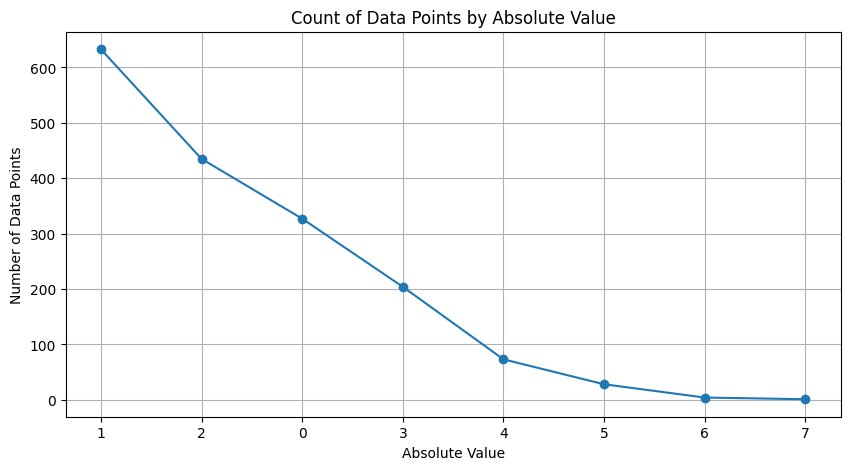

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(df_chatgpt)), df_chatgpt['count'], marker='o')  

plt.xticks(range(len(df_chatgpt)), df_chatgpt['abs_value'])

plt.title('Count of Data Points by Absolute Value') 
plt.xlabel('Absolute Value') 
plt.ylabel('Number of Data Points')  
plt.show()

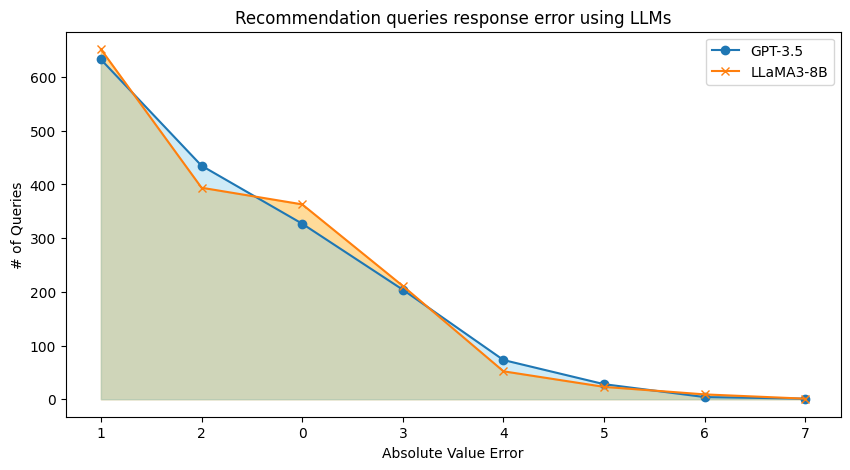

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

x_values = range(len(df_chatgpt))

plt.plot(x_values, df_chatgpt['count'], marker='o', label='GPT-3.5')
plt.plot(x_values, df_llama['count'], marker='x', label='LLaMA3-8B')

plt.fill_between(x_values, df_llama['count'], color="orange", alpha=0.4)
plt.fill_between(x_values, df_chatgpt['count'], color="skyblue", alpha=0.4)

plt.xticks(x_values, df_chatgpt['abs_value'])

plt.legend()

plt.title('Recommendation queries response error using LLMs')  # Title of the graph
plt.xlabel('Absolute Value Error')  # Label for the x-axis
plt.ylabel('# of Queries')  # Label for the y-axis
plt.grid(False)  # Add a grid for easier readability
plt.show()  # Display the graph